In [90]:
!pip install GEOparse
!pip install kneed
!pip install hdbscan

In [91]:
import GEOparse
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde
from sklearn.preprocessing import StandardScaler
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_curve, auc
import shap
from sklearn.cluster import KMeans
import hdbscan
from kneed import KneeLocator
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import fcluster
from sklearn.mixture import GaussianMixture
from sklearn.cluster import OPTICS
from sklearn.cluster import SpectralCoclustering
from matplotlib.patches import Patch
from matplotlib.gridspec import GridSpec
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import warnings
warnings.filterwarnings('ignore')

In [92]:
# Ambil data GDS810 dari GEO
gds = GEOparse.get_GEO("GDS4274")

# Lihat metadata
print(gds.metadata)

# Konversi ke dataframe
df = gds.table
print(df.head())

29-May-2025 16:44:38 DEBUG utils - Directory ./ already exists. Skipping.
DEBUG:GEOparse:Directory ./ already exists. Skipping.
29-May-2025 16:44:38 INFO GEOparse - File already exist: using local version.
INFO:GEOparse:File already exist: using local version.
29-May-2025 16:44:38 INFO GEOparse - Parsing ./GDS4274.soft.gz: 
INFO:GEOparse:Parsing ./GDS4274.soft.gz: 
29-May-2025 16:44:38 DEBUG GEOparse - DATABASE: Geo
DEBUG:GEOparse:DATABASE: Geo
29-May-2025 16:44:38 DEBUG GEOparse - DATASET: GDS4274
DEBUG:GEOparse:DATASET: GDS4274
29-May-2025 16:44:38 DEBUG GEOparse - SUBSET: GDS4274_1
DEBUG:GEOparse:SUBSET: GDS4274_1
29-May-2025 16:44:38 DEBUG GEOparse - SUBSET: GDS4274_2
DEBUG:GEOparse:SUBSET: GDS4274_2
29-May-2025 16:44:38 DEBUG GEOparse - SUBSET: GDS4274_3
DEBUG:GEOparse:SUBSET: GDS4274_3
29-May-2025 16:44:38 DEBUG GEOparse - SUBSET: GDS4274_4
DEBUG:GEOparse:SUBSET: GDS4274_4
29-May-2025 16:44:38 DEBUG GEOparse - SUBSET: GDS4274_5
DEBUG:GEOparse:SUBSET: GDS4274_5
29-May-2025 16:44:3

{'title': ['Stratification of pediatric septic shock patients: whole blood'], 'description': ['Analysis of whole blood from children (up to 10 years old) within 24hrs of PICU admission for septic shock. Heterogeneous clinical phenotypes stratify the septic shock patients. Results provide insight into the molecular mechanisms underlying these septic shock subgroups.'], 'type': ['Expression profiling by array'], 'pubmed_id': ['19624809', '21738952'], 'platform': ['GPL570'], 'platform_organism': ['Homo sapiens'], 'platform_technology_type': ['in situ oligonucleotide'], 'feature_count': ['54675'], 'sample_organism': ['Homo sapiens'], 'sample_type': ['RNA'], 'channel_count': ['1'], 'sample_count': ['130'], 'value_type': ['transformed count'], 'reference_series': ['GSE26440'], 'order': ['none'], 'update_date': ['Feb 21 2014']}
      ID_REF IDENTIFIER  GSM648605  GSM648618  GSM648620  GSM648646  \
0  1007_s_at    MIR4640      0.833      0.810      0.983      0.638   
1    1053_at       RFC2  

In [93]:
# Menampilkan kolom dari objek gds
gds.columns

description    disease state  \
GSM648605  Value for GSM648605: Septic Shock_biological r...     septic shock   
GSM648618  Value for GSM648618: Septic Shock_biological r...     septic shock   
GSM648620  Value for GSM648620: Septic Shock_biological r...     septic shock   
GSM648646  Value for GSM648646: Septic Shock_biological r...     septic shock   
GSM648649  Value for GSM648649: Septic Shock_biological r...     septic shock   
...                                                      ...              ...   
GSM648701  Value for GSM648701: Control_biological rep31 ...  healthy control   
GSM648673  Value for GSM648673: Control_biological rep13 ...  healthy control   
GSM648677  Value for GSM648677: Control_biological rep16 ...  healthy control   
GSM648687  Value for GSM648687: Control_biological rep21 ...  healthy control   
GSM648688  Value for GSM648688: Control_biological rep22 ...  healthy control   

                     development stage    other  
GSM648605      neonate (0.0-0.1 years)  group A  
GSM648618      neonate (0.0-0.1 years)  group A  
GSM648620      neonate (0.0-0.1 years)  group A  
GSM648646      neonate (0.0-0.1 years)  group A  
GSM648649      neonate (0.0-0.1 years)  group A  
...                                ...      ...  
GSM648701      toddler (2.0-5.9 years)      n/a  
GSM648673  school-age (6.0-10.9 years)      n/a  
GSM648677  school-age (6.0-10.9 years)      n/a  
GSM648687  school-age (6.0-10.9 years)      n/a  
GSM648688  school-age (6.0-10.9 years)      n/a  

[130 rows x 4 columns]

In [94]:
# Menampilkan proporsi disease state
gds.columns['disease state'].value_counts()

disease state
septic shock       98
healthy control    32
Name: count, dtype: int64

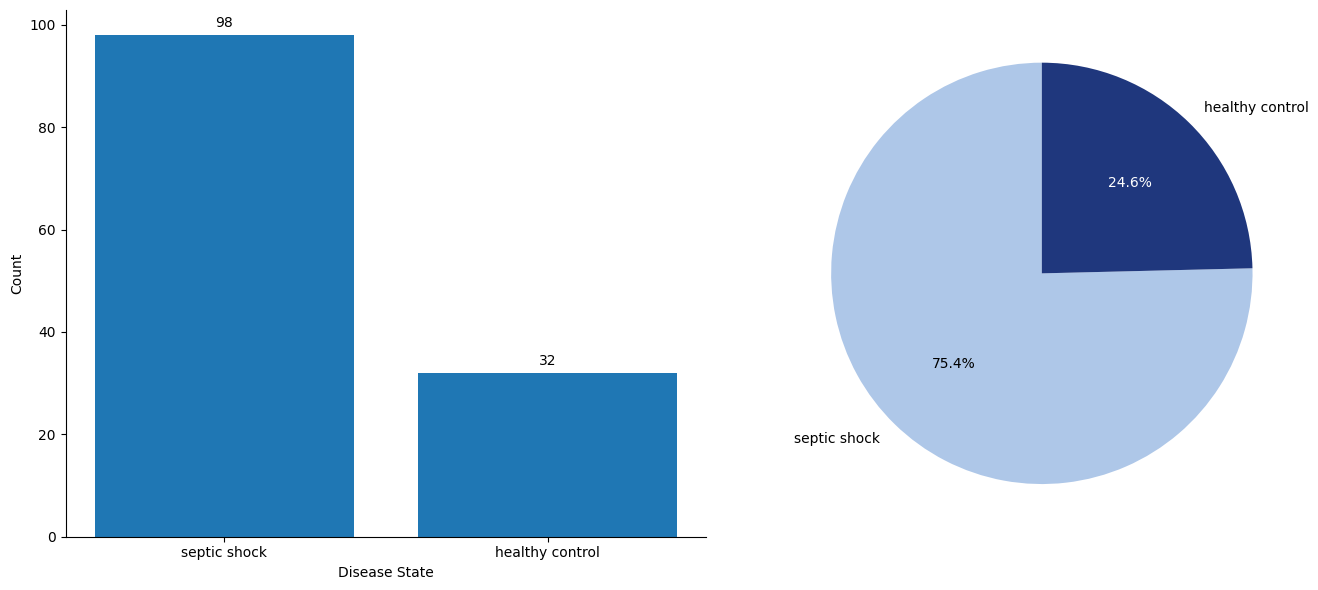

In [95]:
# Distribusi Proporsi Kelas
# Menghitung nilai proporsi
value_counts = gds.columns['disease state'].value_counts()

# Membuat figure dengan dua subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Warna formal untuk bar chart
bar_color = '#1f77b4'

# Warna untuk pie chart (biru muda dan biru tua yang berbeda)
pie_colors = ['#aec7e8', '#1f377d']  # Biru muda dan biru tua (beda dari bar chart)

# Bar Chart di sebelah kiri
axes[0].bar(value_counts.index, value_counts.values, color=bar_color)
axes[0].set_ylabel('Count')
axes[0].set_xlabel('Disease State')

# Menambahkan jumlah nilai di atas setiap bar
for i, v in enumerate(value_counts.values):
    axes[0].text(i, v + 1, str(v), ha='center', va='bottom', fontsize=10)

# Menghapus upper x-axis dan right y-axis
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)

# Pie Chart di sebelah kanan
# Fungsi untuk menampilkan persentase dengan teks putih pada biru tua
def func(pct, allvalues):
    absolute = int(pct / 100.*sum(allvalues))
    return f"{pct:.1f}%"

# Menggambar pie chart dengan warna biru muda dan biru tua
wedges, texts, autotexts = axes[1].pie(value_counts.values, labels=value_counts.index, autopct=lambda pct: func(pct, value_counts.values), startangle=90, colors=pie_colors)

# Menetapkan warna putih hanya untuk persentase di dalam biru tua
for i, autotext in enumerate(autotexts):
    if pie_colors[i] == '#1f377d':  # Biru tua
        autotext.set_color('white')

# Menambahkan persentase di luar pie chart dengan jarak 1 cm
plt.subplots_adjust(wspace=0.4)  # Jarak antara subplots

# Menampilkan plot
plt.tight_layout()
plt.show()

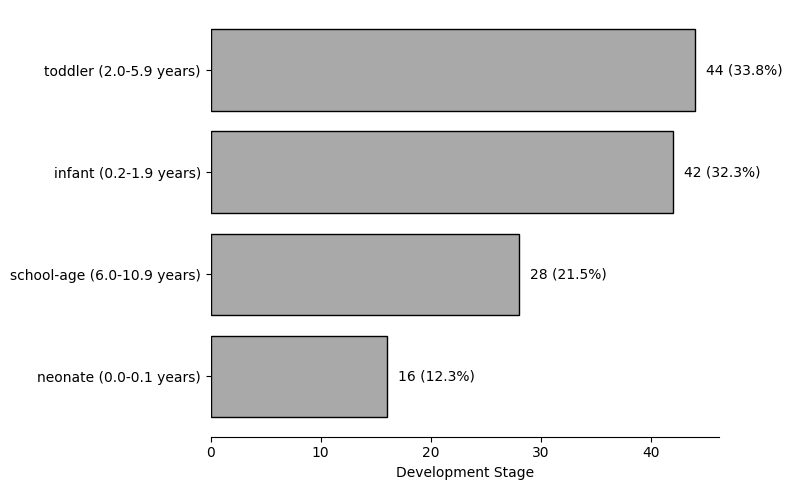

In [96]:
# Menampilkan bar chart untuk development stage
ds = gds.columns['development stage'].value_counts()
ds = ds.sort_values(ascending=True)
labels = ds.index
counts = ds.values
percentages = ds.values / ds.sum() * 100

# Set figure and axes
fig, ax = plt.subplots(figsize=(8, 5))
# fig.suptitle("User", fontsize=14, y=0.95)

# Horizontal Bar Chart
bars = ax.barh(labels, counts, color='darkgrey', edgecolor='black')
for i, bar in enumerate(bars):
    width = bar.get_width()
    ax.text(width + 1, bar.get_y() + bar.get_height()/2,
            f'{counts[i]} ({percentages[i]:.1f}%)',
            va='center', fontsize=10)

ax.set_xlabel('Development Stage')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.tight_layout()
plt.show()

In [97]:
# Ambil hanya data ekspresi
expression_data = df.drop(columns=['ID_REF', 'IDENTIFIER'])

# Ubah ke numerik
expression_data = expression_data.apply(pd.to_numeric, errors='coerce')

# Terapkan log2, hanya untuk nilai > 0
expression_data_log2 = expression_data.applymap(lambda x: np.log2(x) if x > 0 else np.nan)

# Tambahkan kembali ID_REF sebagai indeks
expression_data_log2.index = df['ID_REF']

# Tampilkan hasil
print(expression_data_log2.head())

           GSM648605  GSM648618  GSM648620  GSM648646  GSM648649  GSM648675  \
ID_REF                                                                        
1007_s_at  -0.263612  -0.304006  -0.024737  -0.648372  -0.498179  -0.072483   
1053_at    -0.974262   1.009347  -0.172994  -0.418890   0.126973   1.240009   
117_at     -1.029146  -0.397828  -0.378944  -1.248108  -0.341903  -0.558517   
121_at      0.412511  -0.227692   0.296311   0.424385   0.187768  -0.128156   
1255_g_at   0.007196   0.014355  -0.140826  -0.134477   0.302173   0.089498   

           GSM648682  GSM648698  GSM648708  GSM648628  ...  GSM648668  \
ID_REF                                                 ...              
1007_s_at  -0.380822   0.075875   0.015783   0.456280  ...  -0.021804   
1053_at    -0.798366  -0.063409   0.270230   1.146655  ...  -0.403542   
117_at     -1.862496  -1.438307  -0.545824   0.809826  ...   0.201634   
121_at      0.211635   0.589763   0.217851  -0.628162  ...   0.327687   
1255_g_a

In [98]:
# Menampilkan banyak gen awal
print("Banyak gen awal:", expression_data_log2.shape[0])

Banyak gen awal: 54675


In [99]:
# Menghapus missing value yang ada pada data ekspresi
jumlah_baris_missing = expression_data_log2.isnull().any(axis=1).sum()
print(f"Jumlah baris dengan missing value: {jumlah_baris_missing}")
expression_data_log2.dropna(inplace=True)
print("Banyak gen setelah menghapus missing value:", expression_data_log2.shape[0])

Jumlah baris dengan missing value: 0
Banyak gen setelah menghapus missing value: 54675


In [100]:
# Melakukan filtering gen
# Hitung varians setiap gen
gene_variances = expression_data_log2.var(axis=1)
threshold_variance = gene_variances.quantile(0.95)

# Filter gen dengan varians lebih tinggi dari threshold
filtered_expression = expression_data_log2[gene_variances >= threshold_variance]

In [101]:
# Menampilkan jumlah gen sebelum dan setelah filtering
print("Jumlah gen sebelum penyaringan:", expression_data.shape[0])
print("Jumlah gen setelah penyaringan:", filtered_expression.shape[0])

Jumlah gen sebelum penyaringan: 54675
Jumlah gen setelah penyaringan: 2734


In [102]:
# Untuk expression_data
gene_variances_all = expression_data_log2.var(axis=1)
min_var_all = gene_variances_all.min()
max_var_all = gene_variances_all.max()

print(f"Interval variansi data ekspresi gen sebelum penyaringan: [{min_var_all:.4f}, {max_var_all:.4f}]")

# Untuk filtered_expression
gene_variances_filtered = filtered_expression.var(axis=1)
min_var_filtered = gene_variances_filtered.min()
max_var_filtered = gene_variances_filtered.max()

print(f"Interval variansi data ekspresi gen setelah penyaringan: [{min_var_filtered:.4f}, {max_var_filtered:.4f}]")

Interval variansi data ekspresi gen sebelum penyaringan: [0.0092, 15.4369]
Interval variansi data ekspresi gen setelah penyaringan: [0.9376, 15.4369]


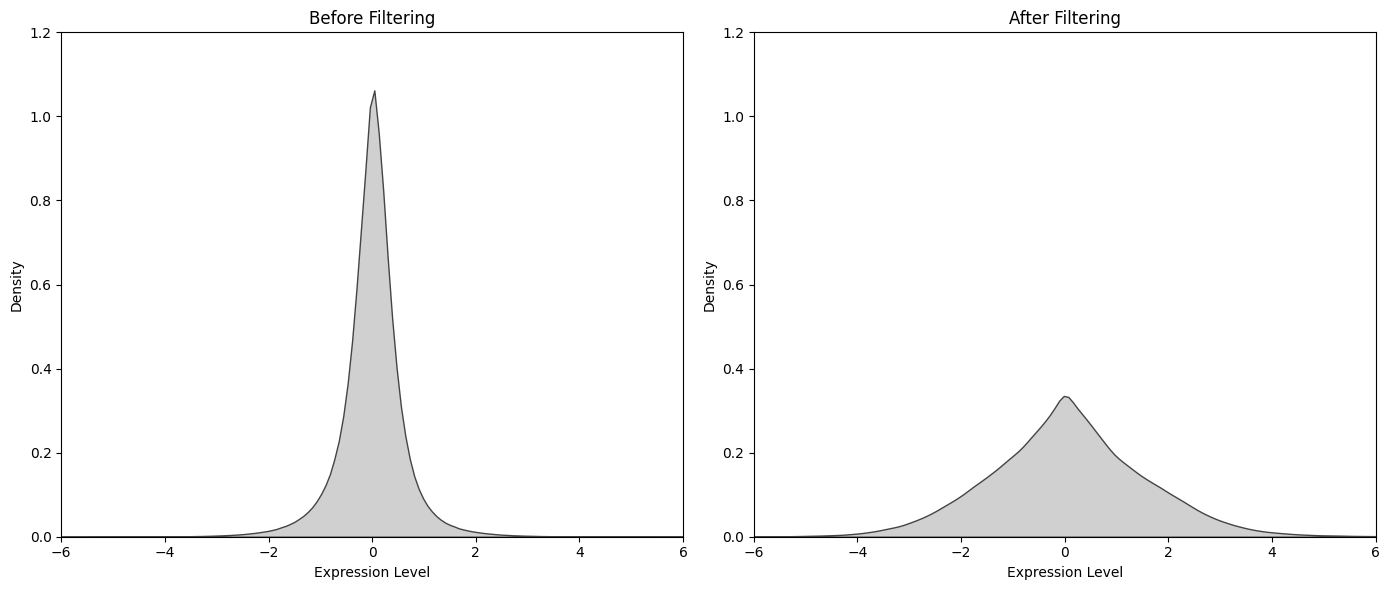

In [103]:
# Misal expression_data dan filtered_expression adalah DataFrame
expression_data_flat = expression_data_log2.values.flatten()
filtered_expression_flat = filtered_expression.values.flatten()

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Before Filtering
sns.kdeplot(expression_data_flat, fill=True, color='#444444', ax=axes[0])
axes[0].set_title('Before Filtering')
axes[0].set_xlabel('Expression Level')
axes[0].set_ylabel('Density')
axes[0].set_xlim(-6, 6)
axes[0].set_ylim(0, 1.2)

# After Filtering
sns.kdeplot(filtered_expression_flat, fill=True, color='#444444', ax=axes[1])
axes[1].set_title('After Filtering')
axes[1].set_xlabel('Expression Level')
axes[1].set_ylabel('Density')
axes[1].set_xlim(-6, 6)
axes[1].set_ylim(0, 1.2)

plt.tight_layout()
plt.show()

In [104]:
# Standarisasi data (scaling) berdasarkan sampel (kolom)
scaler = StandardScaler()

# Standarisasi berdasarkan sampel (kolom), data sudah dalam orientasi yang benar
filtered_expression = filtered_expression.T
scaled_expression = scaler.fit_transform(filtered_expression)

# Membentuk DataFrame setelah standarisasi
scaled_expression_df = pd.DataFrame(scaled_expression, columns=filtered_expression.columns, index=filtered_expression.index)

# Cek hasilnya
print(scaled_expression_df)

ID_REF     1405_i_at  1552263_at  1552274_at  1552316_a_at  1552318_at  \
GSM648605  -0.000652   -1.645801   -1.949701     -2.447088   -1.849886   
GSM648618   0.012389   -0.123432    0.050847      0.177916   -0.459051   
GSM648620   0.237751   -1.350279    0.156502     -0.690208   -0.324636   
GSM648646  -2.799998   -2.910764   -1.672405     -1.625819   -1.266115   
GSM648649  -1.259511    0.348491    0.746066     -0.180928   -0.324636   
...              ...         ...         ...           ...         ...   
GSM648701   1.115891   -0.764938   -1.443371      0.865936    0.591742   
GSM648673   1.218998   -1.166507   -0.804163      1.427171    1.260522   
GSM648677   1.009667   -0.796445   -2.385909     -0.208813   -0.004129   
GSM648687   0.535295   -0.123432    0.140887      0.573200    0.532776   
GSM648688   0.629884    0.208510    0.413718      0.680434    0.768396   

ID_REF     1552398_a_at  1552480_s_at  1552485_at  1552486_s_at  1552553_a_at  \
GSM648605     -0.408756     -1

In [105]:
# Pastikan kolom 'disease state' dari gds.columns diambil
agent_column = gds.columns['disease state']

# Menggabungkan scaled_expression_df dengan agent_column berdasarkan index
merged_df = scaled_expression_df.join(agent_column)

# Menampilkan hasil
print(merged_df.head())

           1405_i_at  1552263_at  1552274_at  1552316_a_at  1552318_at  \
GSM648605  -0.000652   -1.645801   -1.949701     -2.447088   -1.849886   
GSM648618   0.012389   -0.123432    0.050847      0.177916   -0.459051   
GSM648620   0.237751   -1.350279    0.156502     -0.690208   -0.324636   
GSM648646  -2.799998   -2.910764   -1.672405     -1.625819   -1.266115   
GSM648649  -1.259511    0.348491    0.746066     -0.180928   -0.324636   

           1552398_a_at  1552480_s_at  1552485_at  1552486_s_at  1552553_a_at  \
GSM648605     -0.408756     -1.335294    0.529382      0.265909     -0.421084   
GSM648618      0.534992     -1.158756    0.512215      0.735925     -0.076482   
GSM648620      0.367939     -0.383297    0.269477     -0.121456     -0.056970   
GSM648646     -1.807719     -0.616594   -1.526958     -1.381931     -0.639697   
GSM648649      0.222006      0.242600   -0.279615     -0.398407      0.770487   

           ...  63825_at  74694_s_at  87100_at  AFFX-HSAC07/X00351_5

### **Analisis Differentially Expressed Genes**

In [106]:
# Melakukan uji t-test untuk melihat gen yang berbeda
# Pisahkan ekspresi gen dan label 'agent'
expression_data2 = merged_df.drop(columns=['disease state'])
agent_labels = merged_df['disease state']

# Tentukan grup berdasarkan 'disease state'
case_samples = agent_labels[agent_labels == 'septic shock'].index
control_samples = agent_labels[agent_labels == 'healthy control'].index

# Subset ekspresi per grup
case_expr = expression_data2.loc[case_samples]
control_expr = expression_data2.loc[control_samples]

# DEG analysis
p_values = []
logFC = []

for gene in expression_data2.columns:
    expr_case = case_expr[gene]
    expr_control = control_expr[gene]

    # T-test independent
    stat, pval = ttest_ind(expr_case, expr_control, equal_var=False)
    p_values.append(pval)

    # Hitung log fold-change (mean case - mean control)
    mean_case = expr_case.mean()
    mean_control = expr_control.mean()
    log_fc = mean_control - mean_case
    logFC.append(log_fc)

# Koreksi multiple testing (FDR)
adj_p_values = multipletests(p_values, method='fdr_bh')[1]

# Buat DataFrame hasil
deg_results = pd.DataFrame({
    'logFC': logFC,
    'p_value': p_values,
    'adj_p_value': adj_p_values
}, index=expression_data2.columns)

# Tandai gen signifikan
deg_results['significant'] = deg_results['adj_p_value'] < 0.05

# Tampilkan hasil urut dari yang paling signifikan
print(deg_results.sort_values('adj_p_value'))

                 logFC       p_value   adj_p_value  significant
219669_at    -1.977825  9.030392e-48  2.468909e-44         True
208470_s_at  -1.847359  5.142009e-46  7.029127e-43         True
231688_at    -1.835583  1.099337e-41  1.001863e-38         True
219890_at    -1.756804  6.297444e-41  4.304303e-38         True
223767_at    -1.816592  1.264977e-40  6.916896e-38         True
...                ...           ...           ...          ...
205849_s_at   0.001444  9.942000e-01  9.943287e-01        False
241988_x_at   0.001656  9.934468e-01  9.943287e-01        False
208097_s_at  -0.001534  9.937163e-01  9.943287e-01        False
222816_s_at  -0.001598  9.934725e-01  9.943287e-01        False
1553148_a_at  0.001602  9.936377e-01  9.943287e-01        False

[2734 rows x 4 columns]


In [107]:
# 1. Jumlah gen signifikan
jumlah_signifikan = deg_results['significant'].sum()
print(f"Jumlah gen signifikan: {jumlah_signifikan}")

# Filter gen-gen signifikan
significant_genes = deg_results[deg_results['significant']]

# 2. Jumlah gen upregulated
upregulated = significant_genes[significant_genes['logFC'] > 0]
jumlah_upregulated = upregulated.shape[0]
print(f"Jumlah gen upregulated: {jumlah_upregulated}")

# 3. Gen-gen upregulated
gen_upregulated = upregulated.index.values
print("Gen-gen upregulated:")
print(gen_upregulated)

# 4. Jumlah gen downregulated
downregulated = significant_genes[significant_genes['logFC'] < 0]
jumlah_downregulated = downregulated.shape[0]
print(f"Jumlah gen downregulated: {jumlah_downregulated}")

# 5. Gen-gen downregulated
gen_downregulated = downregulated.index.values
print("Gen-gen downregulated:")
print(gen_downregulated)

Jumlah gen signifikan: 2129
Jumlah gen upregulated: 959
Gen-gen upregulated:
['1405_i_at' '1552316_a_at' '1552318_at' '1553132_a_at' '1553177_at'
 '1553589_a_at' '1553678_a_at' '1553856_s_at' '1553979_at' '1554067_at'
 '1554250_s_at' '1554464_a_at' '1554678_s_at' '1554786_at' '1555120_at'
 '1555355_a_at' '1555613_a_at' '1555691_a_at' '1555759_a_at'
 '1555837_s_at' '1555878_at' '1556054_at' '1556402_at' '1556543_at'
 '1556818_at' '1557239_at' '1557580_at' '1557733_a_at' '1557828_a_at'
 '1558093_s_at' '1558111_at' '1558233_s_at' '1558254_s_at' '1558662_s_at'
 '1558700_s_at' '1558956_s_at' '1558971_at' '1558972_s_at' '1559078_at'
 '1559097_at' '1559263_s_at' '1559425_at' '1562364_at' '1562529_s_at'
 '1563217_at' '1563573_at' '1564139_at' '1564776_at' '1567214_a_at'
 '1568609_s_at' '1568815_a_at' '1568934_at' '1568983_a_at' '1569110_x_at'
 '1569225_a_at' '1569652_at' '200002_at' '200026_at' '200036_s_at'
 '200061_s_at' '200063_s_at' '200082_s_at' '200099_s_at' '200626_s_at'
 '200685_at' '2

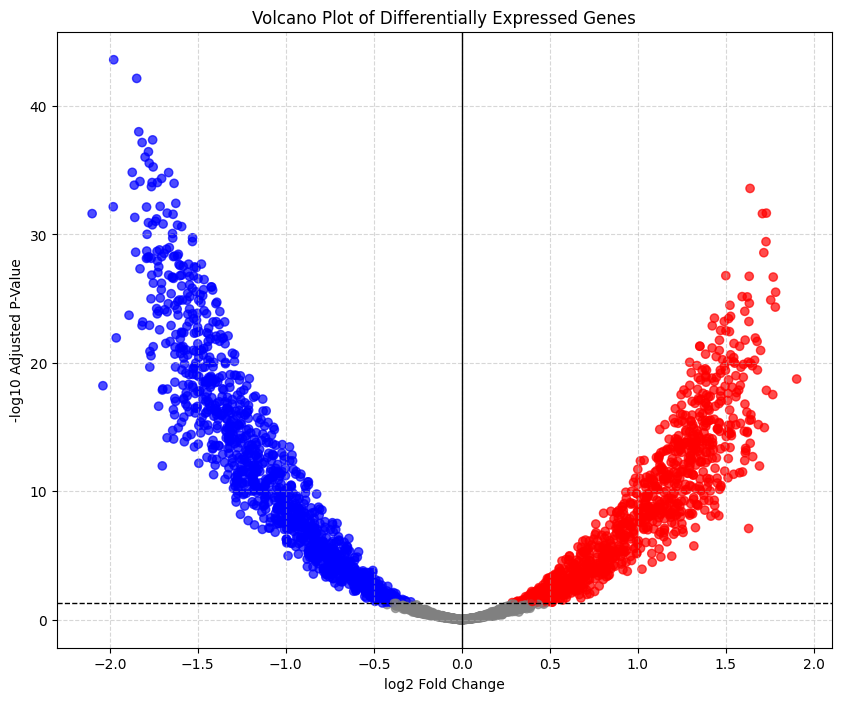

In [108]:
# Menampilkan Volcano Plot
# Siapkan data
logFC = deg_results['logFC']
neg_log10_pval = -np.log10(deg_results['adj_p_value'])

# Tentukan warna berdasarkan status
colors = np.where(
    (deg_results['significant']) & (deg_results['logFC'] > 0), 'red',
    np.where((deg_results['significant']) & (deg_results['logFC'] < 0), 'blue', 'grey')
)

# Plot
plt.figure(figsize=(10, 8))
plt.scatter(logFC, neg_log10_pval, c=colors, alpha=0.7)
plt.title('Volcano Plot of Differentially Expressed Genes')
plt.xlabel('log2 Fold Change')
plt.ylabel('-log10 Adjusted P-Value')
plt.axhline(-np.log10(0.05), color='black', linestyle='--', linewidth=1)  # garis threshold p-value
plt.axvline(0, color='black', linestyle='-', linewidth=1)  # garis tengah logFC=0
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [109]:
# Ambil daftar gen signifikan dari deg_results
significant_genes = deg_results[deg_results['significant']].index

# Filter merged_df hanya untuk gen yang signifikan
filtered_merged_df = merged_df.loc[:, significant_genes]

# Merge kembali kolom 'agent' berdasarkan index
filtered_merged_df = filtered_merged_df.join(merged_df['disease state'])

In [110]:
# Memisahkan X dan y
X = filtered_merged_df.drop(columns=['disease state'])
y = filtered_merged_df['disease state']
y = y.replace({'septic shock': 1, 'healthy control': 0})

In [111]:
# Misalnya, 'target' adalah label kelas yang ingin diprediksi
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [112]:
# Menampilkan proporsi data latih dan data uji
print("Proporsi data latih:", y_train.shape[0])
print("Proporsi data uji:", y_test.shape[0])

Proporsi data latih: 104
Proporsi data uji: 26


### **Analisis Klasifikasi**

#### **Tanpa Resampling**

In [113]:
# Membuat parameter grid untuk tuning
logreg_param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', None],
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga'],
    'max_iter': [100, 200, 500]
}

dt_param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

knn_param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

svm_param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

In [114]:
# Regresi Logistik
logreg = LogisticRegression(random_state=42)
logreg_model = RandomizedSearchCV(
    logreg,
    logreg_param_grid,
    n_iter=10,
    cv=5,
    scoring='accuracy',
    random_state=42
)
logreg_model.fit(X_train, y_train)

# Melakukan prediksi
y_pred_logreg = logreg_model.best_estimator_.predict(X_test)

# Menampilkan metrik evaluasi
print("\n\nClassification Report for Logistic Regression (Tuned):")
print(classification_report(y_test, y_pred_logreg))



Classification Report for Logistic Regression (Tuned):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00        21

    accuracy                           1.00        26
   macro avg       1.00      1.00      1.00        26
weighted avg       1.00      1.00      1.00        26



In [115]:
# Menampilkan best hyperparameter
print("Best Hyperparameters for Logistic Regression:")
print(logreg_model.best_params_)

Best Hyperparameters for Logistic Regression:
{'solver': 'liblinear', 'penalty': 'l1', 'max_iter': 500, 'C': 0.1}


In [116]:
# Menghitung akurasi pada data latih (train accuracy)
train_accuracy = logreg_model.score(X_train, y_train)
print(f"Train Accuracy: {train_accuracy:.4f}")

# Menghitung akurasi pada data uji (test accuracy)
test_accuracy = logreg_model.score(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

Train Accuracy: 0.9808
Test Accuracy: 1.0000


In [117]:
# K-Nearest Neighbors
knn = KNeighborsClassifier()
knn_model = RandomizedSearchCV(
    knn,
    knn_param_grid,
    n_iter=10,
    cv=5,
    scoring='accuracy',
    random_state=42
)
knn_model.fit(X_train, y_train)

# Melakukan prediksi
y_pred_knn = knn_model.best_estimator_.predict(X_test)

# Menampilkan metrik evaluasi
print("\n\nClassification Report for k-Nearest Neighbor (Tuned):")
print(classification_report(y_test, y_pred_knn))



Classification Report for k-Nearest Neighbor (Tuned):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00        21

    accuracy                           1.00        26
   macro avg       1.00      1.00      1.00        26
weighted avg       1.00      1.00      1.00        26



In [118]:
# Menampilkan best hyperparameter
print("Best Hyperparameters for k-Nearest Neighbor:")
print(knn_model.best_params_)

Best Hyperparameters for k-Nearest Neighbor:
{'weights': 'uniform', 'n_neighbors': 3, 'metric': 'manhattan'}


In [119]:
# Menghitung akurasi pada data latih (train accuracy)
train_accuracy = knn_model.score(X_train, y_train)
print(f"Train Accuracy: {train_accuracy:.4f}")

# Menghitung akurasi pada data uji (test accuracy)
test_accuracy = knn_model.score(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

Train Accuracy: 0.9904
Test Accuracy: 1.0000


In [120]:
# SVM
svm = SVC(probability=True, random_state=42)
svm_model = RandomizedSearchCV(
    svm,
    svm_param_grid,
    n_iter=10,
    cv=5,
    scoring='accuracy',
    random_state=42
)
svm_model.fit(X_train, y_train)

# Melakukan prediksi
y_pred_svc = svm_model.best_estimator_.predict(X_test)

# Menampilkan metrik evaluasi
print("\n\nClassification Report for SVM (Tuned):")
print(classification_report(y_test, y_pred_svc))



Classification Report for SVM (Tuned):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00        21

    accuracy                           1.00        26
   macro avg       1.00      1.00      1.00        26
weighted avg       1.00      1.00      1.00        26



In [121]:
# Menampilkan best hyperparameter
print("Best Hyperparameters for SVM:")
print(svm_model.best_params_)

Best Hyperparameters for SVM:
{'kernel': 'linear', 'gamma': 'scale', 'C': 0.1}


In [122]:
# Menghitung akurasi pada data latih (train accuracy)
train_accuracy = svm_model.score(X_train, y_train)
print(f"Train Accuracy: {train_accuracy:.4f}")

# Menghitung akurasi pada data uji (test accuracy)
test_accuracy = svm_model.score(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

Train Accuracy: 1.0000
Test Accuracy: 1.0000


#### **Feature Importance**

In [123]:
# SVM
svm = SVC(probability=True, random_state=42)
svm_model = RandomizedSearchCV(
    svm,
    svm_param_grid,
    n_iter=10,
    cv=5,
    scoring='accuracy',
    random_state=42
)
svm_model.fit(X_train, y_train)

# Melakukan prediksi
y_pred_svc = svm_model.best_estimator_.predict(X_test)

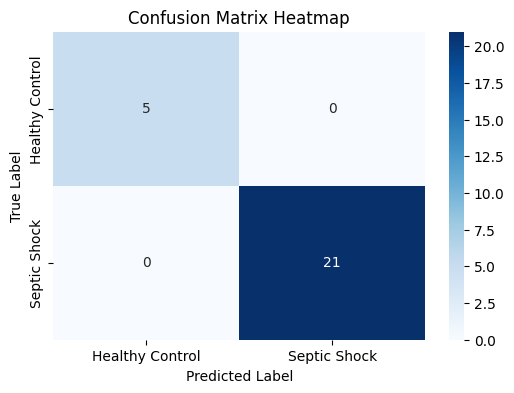

In [124]:
# Buat confusion matrix
cm = confusion_matrix(y_test, y_pred_svc)

# Visualisasikan sebagai heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Healthy Control', 'Septic Shock'],
            yticklabels=['Healthy Control', 'Septic Shock'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')
plt.show()

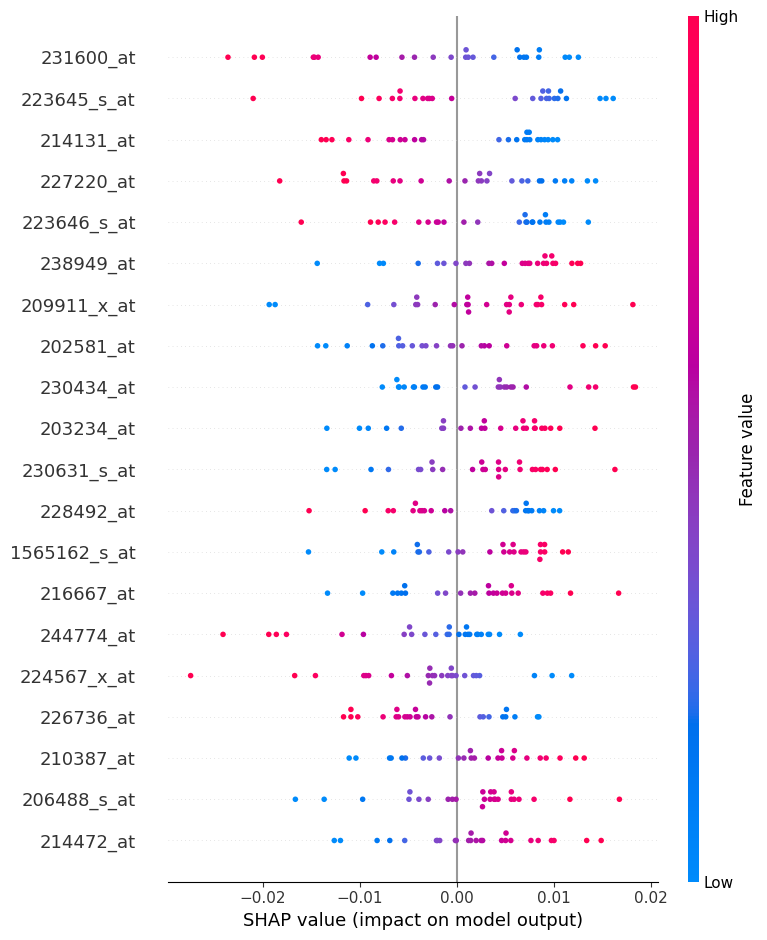

In [125]:
# Inisialisasi explainer
explainer_svm = shap.Explainer(svm_model.best_estimator_, X_train)

# Hitung SHAP values untuk X_test
shap_values_svm = explainer_svm(X_test)

# Summary plot untuk melihat fitur mana yang paling berpengaruh
shap.summary_plot(shap_values_svm, X_test)

In [126]:
# --- 1. Buat explainer hanya untuk SVM ---
explainer_svm = shap.Explainer(svm_model.best_estimator_, X_train)
shap_values_svm = explainer_svm(X_test)

# --- 2. Hitung mean(|SHAP value|) untuk masing-masing fitur dari SVM ---
mean_shap_svm = np.abs(shap_values_svm.values).mean(axis=0)

# --- 3. Buat DataFrame supaya rapi ---
svm_importance = pd.DataFrame({
    'feature': X_test.columns,
    'mean_abs_shap': mean_shap_svm
}).sort_values(by='mean_abs_shap', ascending=False)

# --- 4. Ambil 20 fitur teratas dari SVM ---
top_n = 20
top_features_svm = svm_importance.head(top_n)

print("20 fitur (gen) terpenting menurut model SVM berdasarkan SHAP:")
print(top_features_svm)

20 fitur (gen) terpenting menurut model SVM berdasarkan SHAP:
           feature  mean_abs_shap
1727     231600_at       0.008695
1370   223645_s_at       0.008544
976      214131_at       0.007876
1562     227220_at       0.007651
1371   223646_s_at       0.007209
1949     238949_at       0.007027
746    209911_x_at       0.006912
306      202581_at       0.006904
1694     230434_at       0.006600
353      203234_at       0.006459
1700   230631_s_at       0.006382
1617     228492_at       0.006283
131   1565162_s_at       0.006274
1077     216667_at       0.006041
2109     244774_at       0.005879
1403   224567_x_at       0.005861
1533     226736_at       0.005764
773      210387_at       0.005745
571    206488_s_at       0.005732
988      214472_at       0.005648


In [127]:
# Ambil nama gen dan konversi menjadi array
top_10_gen = np.array(X_test.columns)[np.argsort(mean_shap_svm)[-10:][::-1]]
top_10_gen_list = top_10_gen.tolist()

### **Analisis Clustering**

In [128]:
# Mengambil data ekspresi gen yang sudah dipreprocessing
scaled_exprs_data = X.T
scaled_exprs_data = scaled_exprs_data.iloc[:, :130]

In [129]:
# Mengambol data ekspresi yang sudah dipreprocessing
scaled_expression_df = X.T

In [130]:
# Inisialisasi dan fit PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_exprs_data)

# Buat DataFrame hasil PCA
pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'], index=scaled_exprs_data.index)

#### **K-Means**

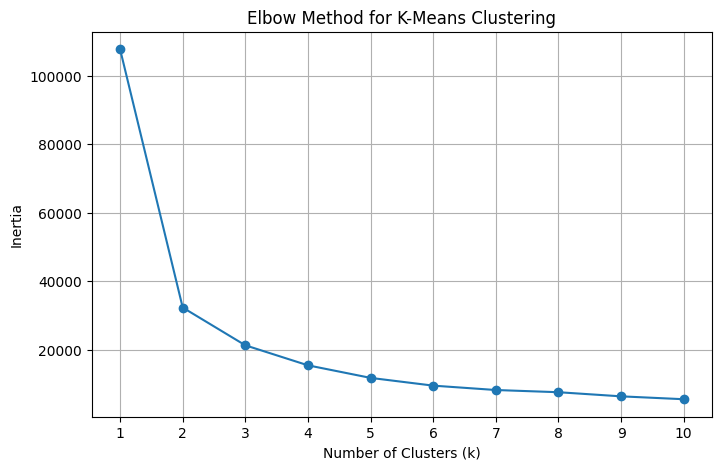

In [131]:
# Menampilkan visualisasi Elbow Method
# Tentukan rentang jumlah klaster yang ingin diuji
cluster_range = range(1, 11)
inertia = []

# Hitung inertia untuk setiap jumlah klaster
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_df)
    inertia.append(kmeans.inertia_)

# Visualisasi elbow method
plt.figure(figsize=(8, 5))
plt.plot(cluster_range, inertia, marker='o')
plt.title('Elbow Method for K-Means Clustering')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(cluster_range)
plt.grid(True)
plt.show()

In [132]:
# Memastikan titik elbow
kl = KneeLocator(range(1, 11), inertia, curve="convex", direction="decreasing")
print("Optimal number of clusters:", kl.elbow)

Optimal number of clusters: 2


In [133]:
# Inisialisasi dan latih model KMeans
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(pca_df)

# Tambahkan hasil klaster ke dalam dataframe
scaled_expression_df['Cluster_KMeans'] = kmeans.labels_

# Lihat distribusi data per klaster
print(scaled_expression_df['Cluster_KMeans'].value_counts())

Cluster_KMeans
1    1168
0     961
Name: count, dtype: int64


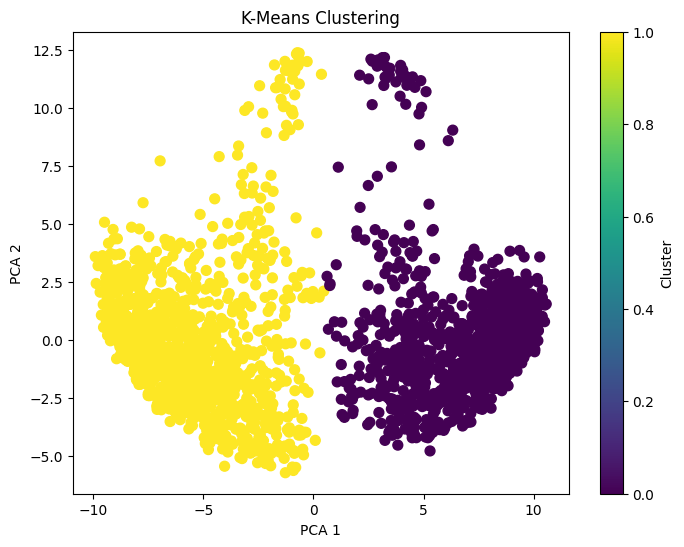

In [134]:
# Plot hasil klaster
plt.figure(figsize=(8, 6))
plt.scatter(pca_df['PC1'], pca_df['PC2'], c=scaled_expression_df['Cluster_KMeans'], cmap='viridis', s=50)
plt.title('K-Means Clustering')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.grid(False)
plt.colorbar(label='Cluster')
plt.show()

In [135]:
# Hitung silhouette score berdasarkan data asli (tanpa PCA)
score = silhouette_score(pca_df,
                         scaled_expression_df['Cluster_KMeans'])

print(f"Silhouette Score untuk KMeans Clustering (k=3): {score:.4f}")

Silhouette Score untuk KMeans Clustering (k=3): 0.6267


#### **Hierarchical Clustering**

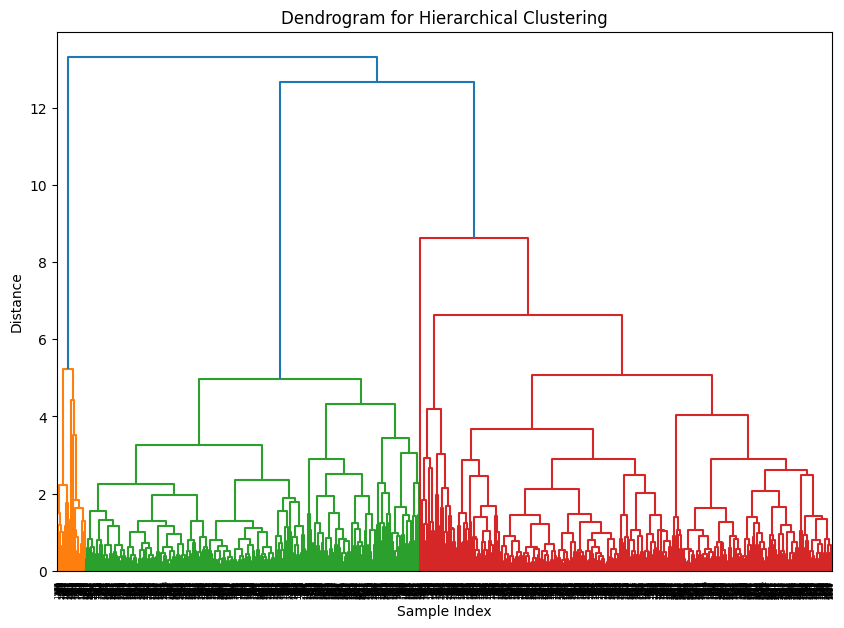

In [136]:
# Membuat linkage matrix menggunakan metode 'average'
Z = sch.linkage(pca_df, method='average')

# Membuat dendrogram
plt.figure(figsize=(10, 7))
sch.dendrogram(Z)
plt.title("Dendrogram for Hierarchical Clustering")
plt.xlabel("Sample Index")
plt.ylabel("Distance")
plt.show()

In [137]:
# Membuat linkage matrix menggunakan metode 'ward'
Z = sch.linkage(pca_df, method='average')

# Menentukan jumlah klaster dengan memotong dendrogram pada tingkat yang sesuai untuk 3 klaster
clusters = fcluster(Z, t=4, criterion='maxclust')

# Menambahkan hasil klaster ke dalam DataFrame
scaled_expression_df['Cluster_Hierarchical'] = clusters

# Lihat distribusi data per klaster
print(scaled_expression_df['Cluster_Hierarchical'].value_counts())

Cluster_Hierarchical
3    1131
2     918
1      79
4       1
Name: count, dtype: int64


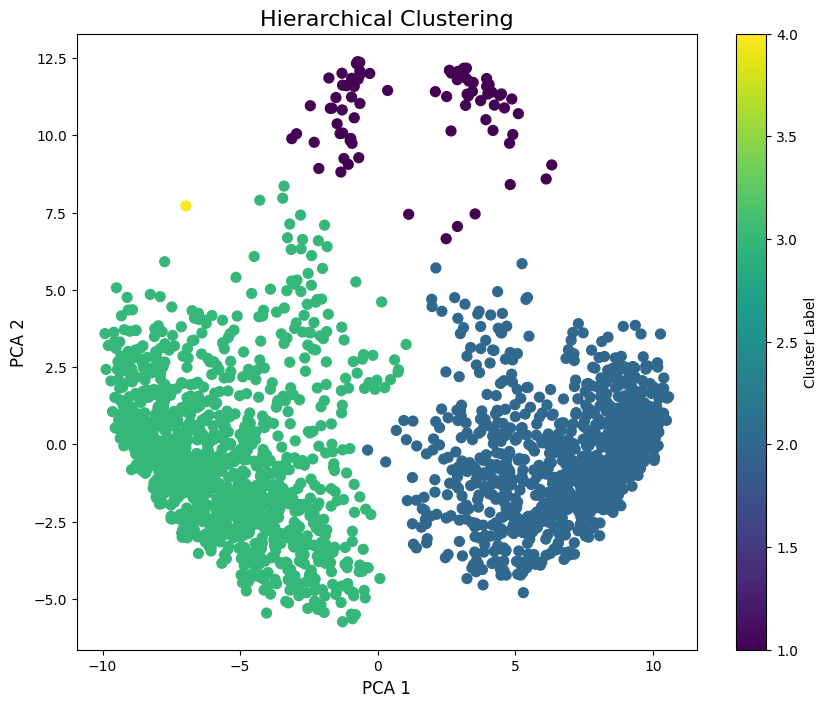

In [138]:
# Plot hasil clustering dengan warna berdasarkan hasil clustering GMM
plt.figure(figsize=(10, 8))
plt.scatter(pca_df['PC1'], pca_df['PC2'],
            c=scaled_expression_df['Cluster_Hierarchical'], cmap='viridis', s=50)
plt.title('Hierarchical Clustering', fontsize=16)
plt.xlabel('PCA 1', fontsize=12)
plt.ylabel('PCA 2', fontsize=12)
plt.colorbar(label='Cluster Label')
plt.show()

In [139]:
# Mengambil hasil clustering Hierarchical (misalnya, dalam kolom 'Cluster_Hierarchical')
labels_hierarchical = scaled_expression_df['Cluster_Hierarchical']

# Menghitung Silhouette Score untuk Hierarchical Clustering
sil_score = silhouette_score(pca_df, labels_hierarchical)

print(f"Silhouette Score untuk Hierarchical Clustering (k=4): {sil_score}")

Silhouette Score untuk Hierarchical Clustering (k=4): 0.5412753304710248


#### **Gaussian Mixture Model**

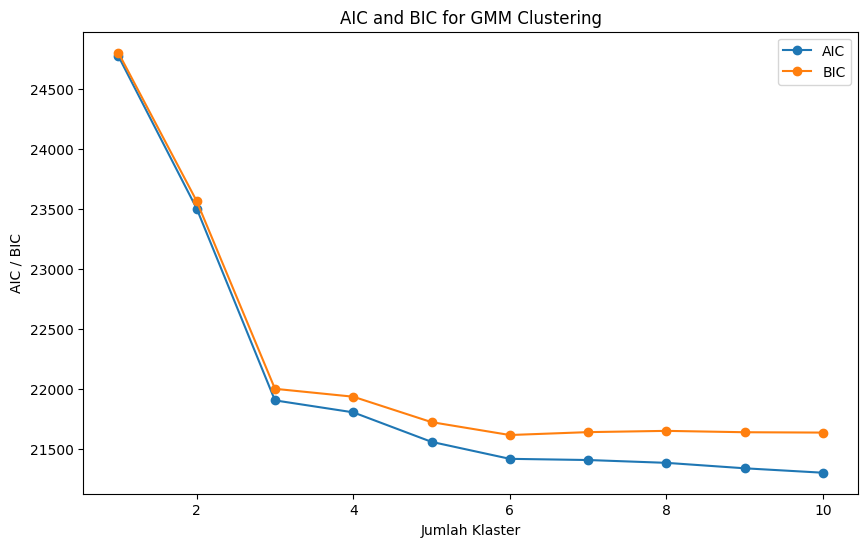

Jumlah klaster optimal berdasarkan AIC: 10
Jumlah klaster optimal berdasarkan BIC: 6


In [140]:
# Menentukan rentang jumlah klaster yang ingin diuji
n_components_range = range(1, 11)

# Menyimpan AIC dan BIC untuk setiap jumlah klaster
aic_scores = []
bic_scores = []

for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(pca_df)  # Gunakan fitur numerik yang sudah dipilih
    aic_scores.append(gmm.aic(pca_df))
    bic_scores.append(gmm.bic(pca_df))

# Visualisasi AIC dan BIC untuk memilih jumlah klaster optimal
plt.figure(figsize=(10, 6))
plt.plot(n_components_range, aic_scores, label='AIC', marker='o')
plt.plot(n_components_range, bic_scores, label='BIC', marker='o')
plt.xlabel('Jumlah Klaster')
plt.ylabel('AIC / BIC')
plt.title('AIC and BIC for GMM Clustering')
plt.legend()
plt.show()

# Menampilkan jumlah klaster optimal berdasarkan AIC dan BIC
optimal_clusters_aic = n_components_range[aic_scores.index(min(aic_scores))]
optimal_clusters_bic = n_components_range[bic_scores.index(min(bic_scores))]

print(f"Jumlah klaster optimal berdasarkan AIC: {optimal_clusters_aic}")
print(f"Jumlah klaster optimal berdasarkan BIC: {optimal_clusters_bic}")

In [141]:
# Menentukan jumlah klaster
n_clusters = 6

# Membuat model GMM dengan jumlah klaster 6
gmm = GaussianMixture(n_components=n_clusters, random_state=42)

# Melatih model GMM pada data numerik
gmm.fit(pca_df)

# Menyimpan hasil klastering
scaled_expression_df['Cluster_GMM'] = gmm.predict(pca_df)

# Lihat distribusi data per klaster
print(scaled_expression_df['Cluster_GMM'].value_counts())

Cluster_GMM
4    536
1    488
3    471
0    376
5    183
2     75
Name: count, dtype: int64


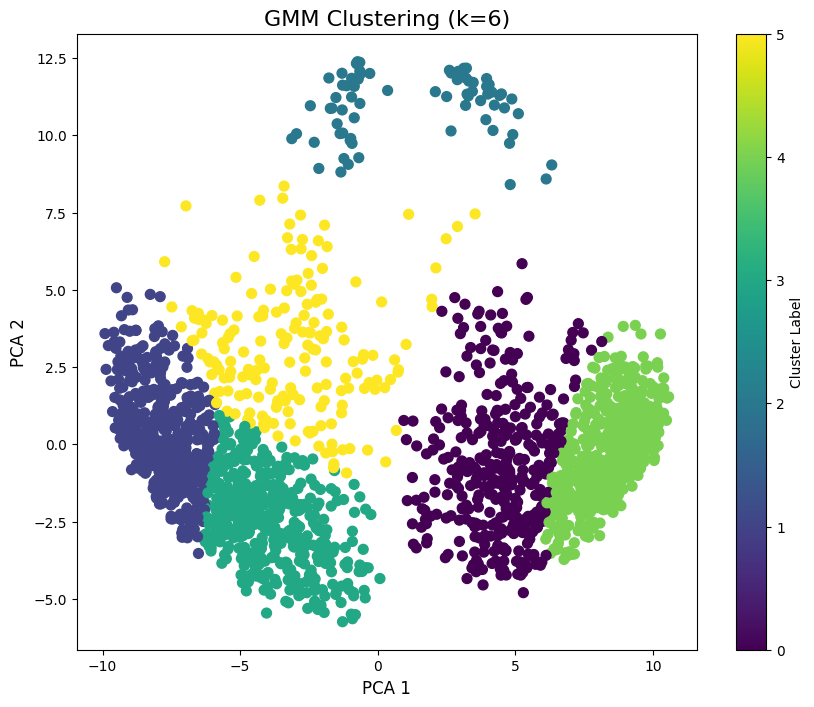

In [142]:
# Plot hasil clustering dengan warna berdasarkan hasil clustering GMM
plt.figure(figsize=(10, 8))
plt.scatter(pca_df['PC1'], pca_df['PC2'],
            c=scaled_expression_df['Cluster_GMM'], cmap='viridis', s=50)
plt.title('GMM Clustering (k=6)', fontsize=16)
plt.xlabel('PCA 1', fontsize=12)
plt.ylabel('PCA 2', fontsize=12)
plt.colorbar(label='Cluster Label')
plt.show()

In [143]:
# Menghitung silhouette score untuk clustering GMM
sil_score = silhouette_score(pca_df, scaled_expression_df['Cluster_GMM'])

# Menampilkan silhouette score
print(f"Silhouette Score untuk GMM Clustering (k=6): {sil_score:.4f}")

Silhouette Score untuk GMM Clustering (k=6): 0.4232


In [144]:
# Menentukan jumlah klaster
n_clusters = 10

# Membuat model GMM dengan jumlah klaster 10
gmm = GaussianMixture(n_components=n_clusters, random_state=42)

# Melatih model GMM pada data numerik
gmm.fit(pca_df)

# Menyimpan hasil klastering
scaled_expression_df['Cluster_GMM2'] = gmm.predict(pca_df)

# Lihat distribusi data per klaster
print(scaled_expression_df['Cluster_GMM2'].value_counts())

Cluster_GMM2
6    328
1    318
0    282
3    278
9    245
7    187
5    156
4    148
8    115
2     72
Name: count, dtype: int64


In [145]:
# Menghitung silhouette score untuk clustering GMM
sil_score = silhouette_score(pca_df, scaled_expression_df['Cluster_GMM2'])

# Menampilkan silhouette score
print(f"Silhouette Score untuk GMM Clustering (k=10): {sil_score:.4f}")

Silhouette Score untuk GMM Clustering (k=10): 0.3584


Karena nilai sihouette score yang diperoleh menunjukkan pemisahan cluster yang dirasa belum optimal. Sehingga kami akan mencoba untuk menerapkan metode clustering yang dapat mendeteksi outlier.

#### **HBDSCAN**

In [146]:
# Range nilai min_cluster_size
min_cluster_range = range(20, 51, 5)

# Loop untuk setiap nilai min_cluster_size
for min_size in min_cluster_range:
    clusterer = hdbscan.HDBSCAN(min_cluster_size=min_size, metric='euclidean')
    labels = clusterer.fit_predict(pca_df)

    # Cek jumlah klaster valid (tanpa outlier)
    n_clusters = len(np.unique(labels[labels != -1]))

    print(f"\nmin_cluster_size = {min_size}")
    print(f"Jumlah klaster (tanpa outlier): {n_clusters}")

    # Hitung silhouette score hanya jika ada > 1 klaster
    if n_clusters > 1:
        sil_score = silhouette_score(pca_df[labels != -1], labels[labels != -1])
        print(f"Silhouette Score: {sil_score:.4f}")
    else:
        print("Silhouette Score tidak dihitung (kurang dari 2 klaster)")


min_cluster_size = 20
Jumlah klaster (tanpa outlier): 5
Silhouette Score: 0.5162

min_cluster_size = 25
Jumlah klaster (tanpa outlier): 3
Silhouette Score: 0.6728

min_cluster_size = 30
Jumlah klaster (tanpa outlier): 3
Silhouette Score: 0.6748

min_cluster_size = 35
Jumlah klaster (tanpa outlier): 2
Silhouette Score: 0.6824

min_cluster_size = 40
Jumlah klaster (tanpa outlier): 2
Silhouette Score: 0.6889

min_cluster_size = 45
Jumlah klaster (tanpa outlier): 2
Silhouette Score: 0.7056

min_cluster_size = 50
Jumlah klaster (tanpa outlier): 2
Silhouette Score: 0.7114


In [147]:
# Jalankan HDBSCAN
clusterer = hdbscan.HDBSCAN(min_cluster_size=50, metric='euclidean')
cluster_labels = clusterer.fit_predict(pca_df)

# Tambahkan kolom label klaster ke DataFrame
scaled_expression_df['Cluster_HDBSCAN'] = cluster_labels

# Hitung jumlah klaster dan outlier
n_clusters = len(np.unique(cluster_labels[cluster_labels != -1]))
n_outliers = np.sum(cluster_labels == -1)

# Output ringkasan
print(scaled_expression_df[['Cluster_HDBSCAN']].value_counts())

Cluster_HDBSCAN
 1                 1037
 0                  856
-1                  236
Name: count, dtype: int64


In [148]:
# Menghitung silhouette score
mask = cluster_labels != -1
sil_score = silhouette_score(pca_df[mask], cluster_labels[mask])
print(f'Silhouette Score: {sil_score:.3f}')

Silhouette Score: 0.711


#### **OPTICS**

In [149]:
# Range nilai min_cluster_size
min_samples_range = range(20, 51, 5)

for min_s in min_samples_range:
    optics_model = OPTICS(min_samples=min_s, metric='euclidean')
    labels = optics_model.fit_predict(pca_df)

    # Buang outlier (-1)
    mask = labels != -1
    filtered_data = pca_df[mask]
    filtered_labels = labels[mask]

    # Hitung jumlah klaster unik tanpa outlier
    num_clusters = len(np.unique(filtered_labels))

    # Hitung silhouette score jika ada minimal 2 klaster
    if num_clusters > 1:
        score = silhouette_score(filtered_data, filtered_labels)
        print(f"min_cluster_size = {min_s}")
        print(f"Jumlah klaster (tanpa outlier): {num_clusters}")
        print(f"Silhouette Score: {score:.4f}\n")
    else:
        print(f"min_cluster_size = {min_s}")
        print("Jumlah klaster tidak cukup untuk hitung silhouette score.\n")

min_cluster_size = 20
Jumlah klaster (tanpa outlier): 7
Silhouette Score: 0.7066

min_cluster_size = 25
Jumlah klaster (tanpa outlier): 3
Silhouette Score: 0.6905

min_cluster_size = 30
Jumlah klaster (tanpa outlier): 4
Silhouette Score: 0.6388

min_cluster_size = 35
Jumlah klaster (tanpa outlier): 2
Silhouette Score: 0.7402

min_cluster_size = 40
Jumlah klaster tidak cukup untuk hitung silhouette score.

min_cluster_size = 45
Jumlah klaster tidak cukup untuk hitung silhouette score.

min_cluster_size = 50
Jumlah klaster tidak cukup untuk hitung silhouette score.



In [150]:
# Inisialisasi dan jalankan OPTICS
optics_model = OPTICS(min_samples=35, metric='euclidean')
cluster_labels_optics = optics_model.fit_predict(pca_df)

# Simpan ke kolom baru jika perlu (opsional)
scaled_expression_df['Cluster_OPTICS'] = cluster_labels_optics

# Tampilkan distribusi label (termasuk outlier = -1)
print(scaled_expression_df['Cluster_OPTICS'].value_counts())

Cluster_OPTICS
-1    1180
 0     914
 1      35
Name: count, dtype: int64


#### **Visualisasi Hasil Clustering**

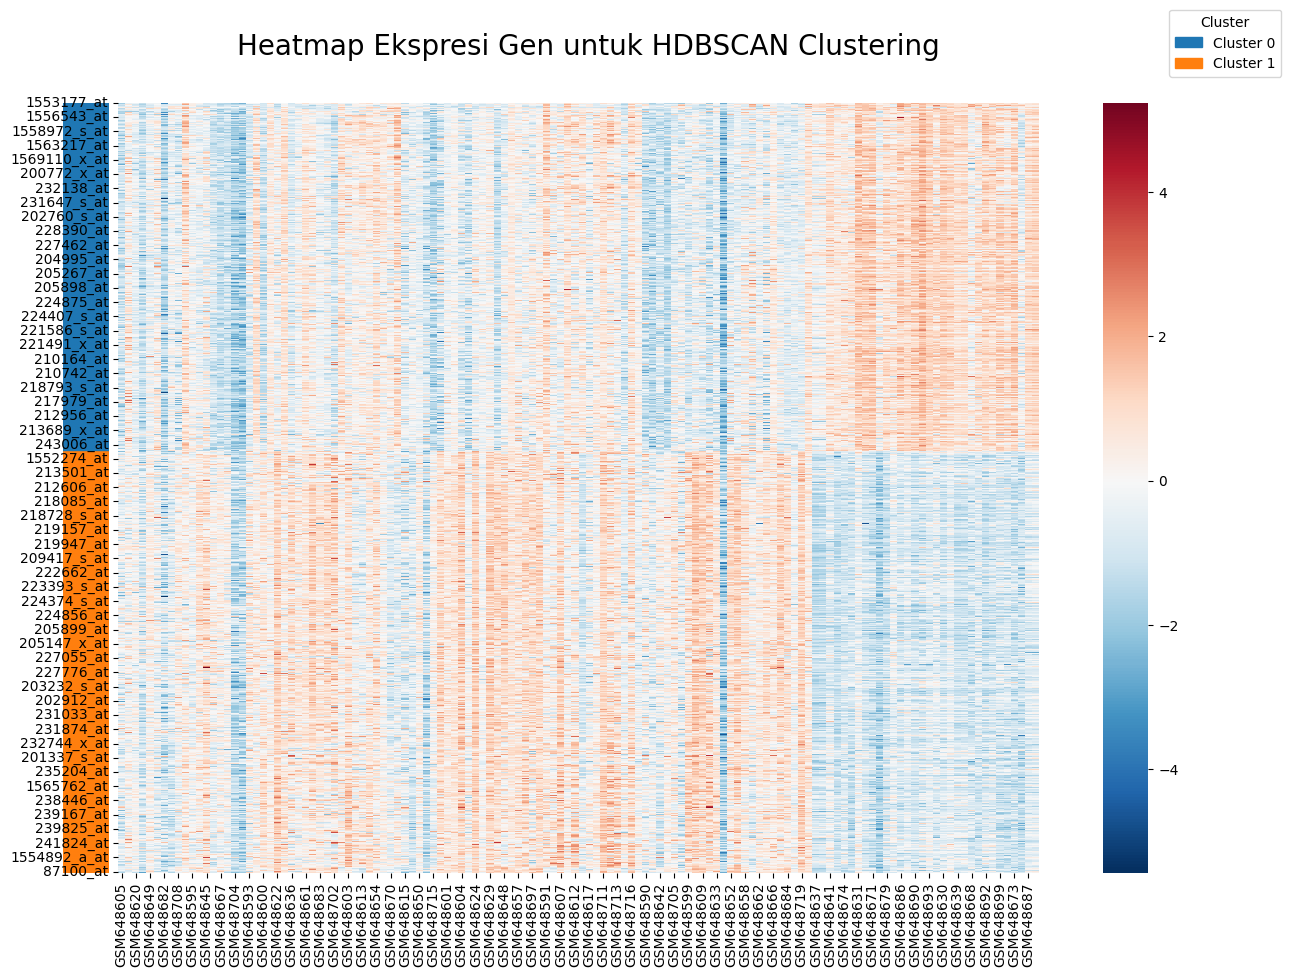

In [151]:
# Menampilkan visualisasi heatmap hasil clustering
clusters = ['Cluster_KMeans', 'Cluster_Hierarchical', 'Cluster_GMM', 'Cluster_GMM2', 'Cluster_HDBSCAN', 'Cluster_OPTICS']
mask = scaled_expression_df['Cluster_HDBSCAN'].isin([0, 1])
data_for_heatmap = scaled_expression_df.loc[mask].drop(columns=clusters)
cluster_order = scaled_expression_df.loc[mask, 'Cluster_HDBSCAN']

# Urutkan berdasarkan cluster
sorted_idx = cluster_order.sort_values().index
data_sorted = data_for_heatmap.loc[sorted_idx]
cluster_sorted = cluster_order.loc[sorted_idx]

# Map warna
cluster_palette = {0: '#1f77b4', 1: '#ff7f0e'}
row_colors = cluster_sorted.map(cluster_palette)

# Convert to numpy array bentuk (n_samples, 1)
row_color_array = np.array(row_colors.map(lambda x: [x]).tolist())

# Buat figure dan gridspec
fig = plt.figure(figsize=(14, 10))
gs = fig.add_gridspec(1, 20)

# Axis untuk row color
ax_colors = fig.add_subplot(gs[0, 0:1])
ax_heatmap = fig.add_subplot(gs[0, 1:18])
ax_cb_cluster = None
ax_cb_zscore = fig.add_subplot(gs[0, 19])

# Plot row colors (pakai imshow dengan ListedColormap)
cmap_row = ListedColormap([cluster_palette[0], cluster_palette[1]])
ax_colors.imshow(cluster_sorted.values.reshape(-1, 1), aspect='auto', cmap=cmap_row, vmin=0, vmax=1)
ax_colors.axis('off')

# Plot heatmap
sns.heatmap(data_sorted, ax=ax_heatmap, cmap='RdBu_r', center=0, cbar_ax=ax_cb_zscore)

# Legend cluster di kanan atas
handles = [Patch(color=color, label=f'Cluster {i}') for i, color in cluster_palette.items()]
fig.legend(handles=handles,
           loc='upper right',
           bbox_to_anchor=(1, 0.98),  # << GESER LEBIH KANAN DAN ATAS
           title='Cluster')

# Judul
plt.suptitle('Heatmap Ekspresi Gen untuk HDBSCAN Clustering', fontsize=20, y=0.95)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

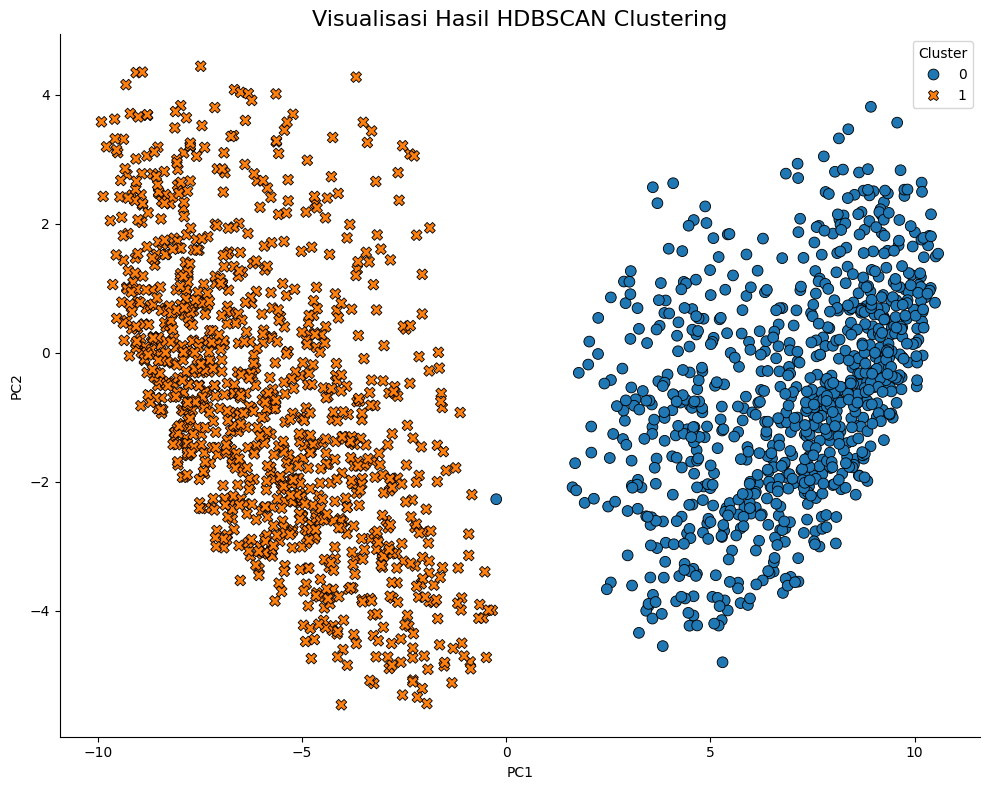

In [152]:
# Ubah cluster_labels ke Series dengan index dari pca_df
cluster_labels = cluster_labels.astype(int)  # Pastikan bertipe integer
cluster_series = pd.Series(cluster_labels, index=pca_df.index)

# Filter hanya cluster 0 dan 1 (tidak termasuk -1)
mask_clusters = cluster_series != -1
filtered_pca = pca_df[mask_clusters].copy()  # Gunakan .copy() agar aman saat menambahkan kolom
filtered_labels = cluster_series[mask_clusters]

# Buat DataFrame untuk visualisasi
scatter_df = filtered_pca
scatter_df['Cluster'] = filtered_labels

# Plot
plt.figure(figsize=(10, 8))
palette = {0: '#1f77b4', 1: '#ff7f0e'}  # Warna untuk cluster 0 dan 1
sns.scatterplot(
    data=scatter_df,
    x='PC1',
    y='PC2',
    hue='Cluster',
    palette=palette,
    style='Cluster',
    s=60,
    edgecolor='k'
)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.title('Visualisasi Hasil HDBSCAN Clustering', fontsize=16)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(title='Cluster', loc='best')
plt.tight_layout()
plt.show()

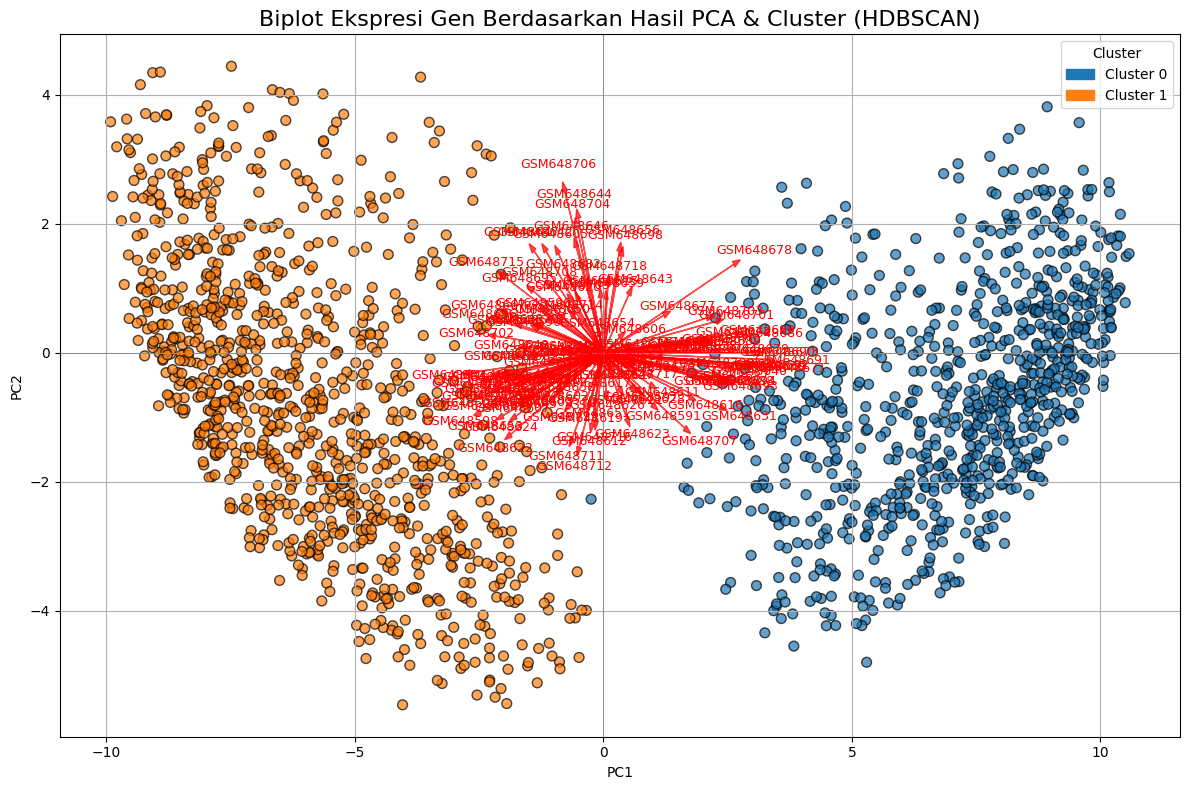

In [153]:
# Ambil label cluster dan buang outlier (-1)
cluster_labels = scaled_expression_df['Cluster_HDBSCAN']
valid_mask = cluster_labels != -1

# Filter PCA dan cluster
filtered_pca_df = pca_df[valid_mask]
filtered_clusters = cluster_labels[valid_mask]

# Buat biplot
plt.figure(figsize=(12, 8))

# Warna cluster
palette = {0: '#1f77b4', 1: '#ff7f0e'}
colors = filtered_clusters.map(palette)

# Plot titik gen (hasil PCA)
plt.scatter(filtered_pca_df['PC1'], filtered_pca_df['PC2'],
            c=colors, s=50, alpha=0.7, edgecolor='k')

# Tambahkan panah untuk tiap sampel (loading)
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

for i, sample in enumerate(scaled_exprs_data.columns):
    plt.arrow(0, 0, loadings[i, 0]*3, loadings[i, 1]*3,
              color='red', alpha=0.7, head_width=0.1, length_includes_head=True)
    plt.text(loadings[i, 0]*3.3, loadings[i, 1]*3.3, sample,
             color='red', ha='center', va='center', fontsize=9)

# Legenda cluster
handles = [Patch(color=color, label=f'Cluster {i}') for i, color in palette.items()]
plt.legend(handles=handles, title='Cluster', loc='best')

# Tata letak plot
plt.title('Biplot Ekspresi Gen Berdasarkan Hasil PCA & Cluster (HDBSCAN)', fontsize=16)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.axhline(0, color='gray', linewidth=0.5)
plt.axvline(0, color='gray', linewidth=0.5)
plt.grid(True)
plt.tight_layout()
plt.show()

### **Analisis Biclustering**

#### **Spectral**

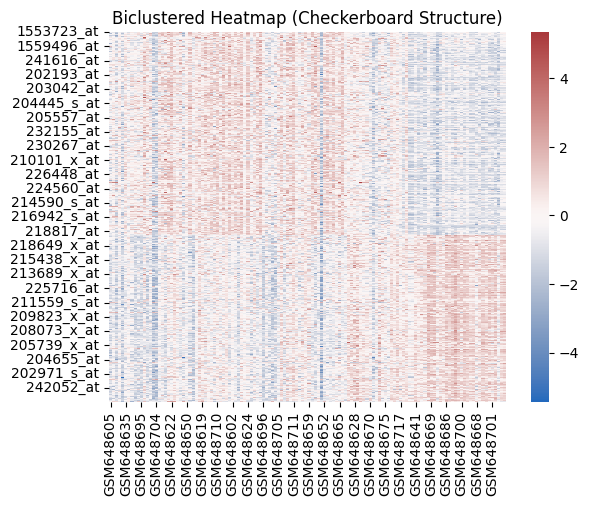

In [154]:
# Jalankan model biclustering
model = SpectralCoclustering(n_clusters=2, random_state=0)
model.fit(scaled_exprs_data)

# Urutkan data berdasarkan hasil biclustering
fit_data = scaled_exprs_data.iloc[np.argsort(model.row_labels_)]
fit_data = fit_data.iloc[:, np.argsort(model.column_labels_)]

sns.heatmap(fit_data, cmap="vlag")
plt.title("Biclustered Heatmap (Checkerboard Structure)")
plt.show()

In [155]:
# Hitung MSR dan VAF
X = scaled_exprs_data.values
overall_mean = X.mean()
row_labels = model.row_labels_
col_labels = model.column_labels_
n_clusters = model.n_clusters

results = []

for i in range(n_clusters):
    row_idx, col_idx = model.get_indices(i)
    bicluster = X[np.ix_(row_idx, col_idx)]

    # Hitung MSR
    row_mean = bicluster.mean(axis=1, keepdims=True)
    col_mean = bicluster.mean(axis=0, keepdims=True)
    bicluster_mean = bicluster.mean()

    msr = np.mean((bicluster - row_mean - col_mean + bicluster_mean) ** 2)

    # Hitung VAF
    numerator = np.sum((bicluster - bicluster.mean()) ** 2)
    denominator = np.sum((bicluster - overall_mean) ** 2)
    vaf = 1 - (numerator / denominator) if denominator != 0 else 0

    results.append({
        'Bicluster': i,
        'MSR': msr,
        'VAF': vaf,
        'n_genes': len(row_idx),
        'n_samples': len(col_idx)
    })

# Tampilkan sebagai DataFrame
result_df = pd.DataFrame(results)
print(result_df)

# Hitung rata-rata MSR dan VAF
avg_msr = result_df['MSR'].mean()
avg_vaf = result_df['VAF'].mean()

print(f"Rata-rata MSR dari seluruh bicluster: {avg_msr:.4f}")
print(f"Rata-rata VAF dari seluruh bicluster: {avg_vaf:.4f}")

   Bicluster       MSR       VAF  n_genes  n_samples
0          0  0.599816  0.120278     1170         78
1          1  0.402606  0.334259      959         52
Rata-rata MSR dari seluruh bicluster: 0.5012
Rata-rata VAF dari seluruh bicluster: 0.2273


In [156]:
# --- Hitung coherence score (variansi bicluster) ---
coherence_scores = []

for i in range(model.n_clusters):
    rows = model.rows_[i]
    cols = model.columns_[i]

    bicluster = scaled_exprs_data.values[np.ix_(rows, cols)]

    if bicluster.size > 0:
        variance = np.var(bicluster)
        coherence_scores.append(variance)
    else:
        coherence_scores.append(np.nan)

# --- Tampilkan hasil coherence ---
for i, score in enumerate(coherence_scores):
    print(f"Bicluster {i+1}: Variansi = {score:.4f}")

# --- Hitung dan tampilkan rata-rata variansi ---
valid_scores = [score for score in coherence_scores if not np.isnan(score)]
average_variance = np.mean(valid_scores)
print(f"\nRata-rata variansi semua bicluster: {average_variance:.4f}")

Bicluster 1: Variansi = 0.9160
Bicluster 2: Variansi = 0.6587

Rata-rata variansi semua bicluster: 0.7873


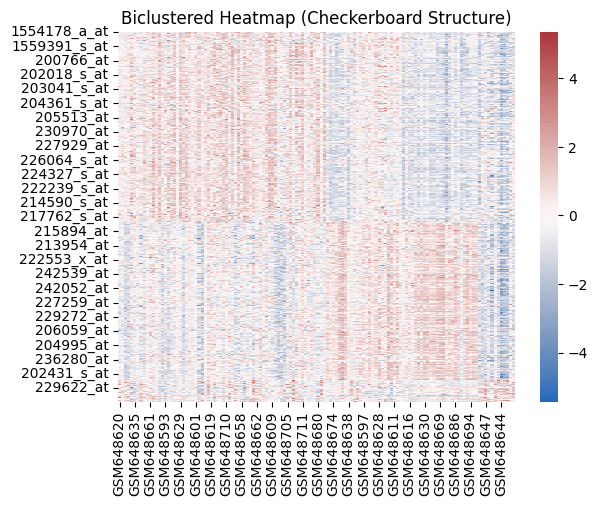

In [157]:
# Jalankan model biclustering
model = SpectralCoclustering(n_clusters=3, random_state=0)
model.fit(scaled_exprs_data)

# Urutkan data berdasarkan hasil biclustering
fit_data = scaled_exprs_data.iloc[np.argsort(model.row_labels_)]
fit_data = fit_data.iloc[:, np.argsort(model.column_labels_)]

sns.heatmap(fit_data, cmap="vlag")
plt.title("Biclustered Heatmap (Checkerboard Structure)")
plt.show()

In [158]:
# Hitung MSR dan VAF
X = scaled_exprs_data.values
overall_mean = X.mean()
row_labels = model.row_labels_
col_labels = model.column_labels_
n_clusters = model.n_clusters

results = []

for i in range(n_clusters):
    row_idx, col_idx = model.get_indices(i)
    bicluster = X[np.ix_(row_idx, col_idx)]

    # Hitung MSR
    row_mean = bicluster.mean(axis=1, keepdims=True)
    col_mean = bicluster.mean(axis=0, keepdims=True)
    bicluster_mean = bicluster.mean()

    msr = np.mean((bicluster - row_mean - col_mean + bicluster_mean) ** 2)

    # Hitung VAF
    numerator = np.sum((bicluster - bicluster.mean()) ** 2)
    denominator = np.sum((bicluster - overall_mean) ** 2)
    vaf = 1 - (numerator / denominator) if denominator != 0 else 0

    results.append({
        'Bicluster': i,
        'MSR': msr,
        'VAF': vaf,
        'n_genes': len(row_idx),
        'n_samples': len(col_idx)
    })

# Tampilkan sebagai DataFrame
result_df = pd.DataFrame(results)
print(result_df)

# Hitung rata-rata MSR dan VAF
avg_msr = result_df['MSR'].mean()
avg_vaf = result_df['VAF'].mean()

print(f"Rata-rata MSR dari seluruh bicluster: {avg_msr:.4f}")
print(f"Rata-rata VAF dari seluruh bicluster: {avg_vaf:.4f}")

   Bicluster       MSR       VAF  n_genes  n_samples
0          0  0.489011  0.292909     1093         68
1          1  0.367187  0.409523      909         50
2          2  0.824950  0.357433      127         12
Rata-rata MSR dari seluruh bicluster: 0.5604
Rata-rata VAF dari seluruh bicluster: 0.3533


In [159]:
# --- Hitung coherence score (variansi bicluster) ---
coherence_scores = []

for i in range(model.n_clusters):
    rows = model.rows_[i]
    cols = model.columns_[i]

    bicluster = scaled_exprs_data.values[np.ix_(rows, cols)]

    if bicluster.size > 0:
        variance = np.var(bicluster)
        coherence_scores.append(variance)
    else:
        coherence_scores.append(np.nan)

# --- Tampilkan hasil coherence ---
for i, score in enumerate(coherence_scores):
    print(f"Bicluster {i+1}: Variansi = {score:.4f}")

# --- Hitung dan tampilkan rata-rata variansi ---
valid_scores = [score for score in coherence_scores if not np.isnan(score)]
average_variance = np.mean(valid_scores)
print(f"\nRata-rata variansi semua bicluster: {average_variance:.4f}")

Bicluster 1: Variansi = 0.6748
Bicluster 2: Variansi = 0.5920
Bicluster 3: Variansi = 1.2784

Rata-rata variansi semua bicluster: 0.8484


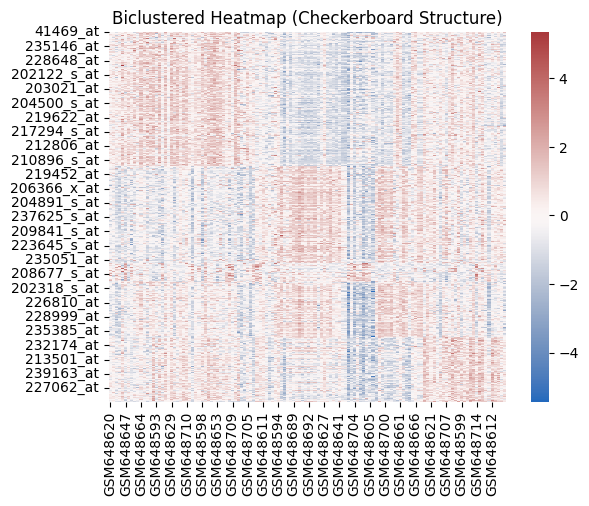

In [160]:
# Jalankan model biclustering
model = SpectralCoclustering(n_clusters=5, random_state=0)
model.fit(scaled_exprs_data)

# Urutkan data berdasarkan hasil biclustering
fit_data = scaled_exprs_data.iloc[np.argsort(model.row_labels_)]
fit_data = fit_data.iloc[:, np.argsort(model.column_labels_)]

sns.heatmap(fit_data, cmap="vlag")
plt.title("Biclustered Heatmap (Checkerboard Structure)")
plt.show()

In [161]:
# Hitung MSR dan VAF
X = scaled_exprs_data.values
overall_mean = X.mean()
row_labels = model.row_labels_
col_labels = model.column_labels_
n_clusters = model.n_clusters

results = []

for i in range(n_clusters):
    row_idx, col_idx = model.get_indices(i)
    bicluster = X[np.ix_(row_idx, col_idx)]

    # Hitung MSR
    row_mean = bicluster.mean(axis=1, keepdims=True)
    col_mean = bicluster.mean(axis=0, keepdims=True)
    bicluster_mean = bicluster.mean()

    msr = np.mean((bicluster - row_mean - col_mean + bicluster_mean) ** 2)

    # Hitung VAF
    numerator = np.sum((bicluster - bicluster.mean()) ** 2)
    denominator = np.sum((bicluster - overall_mean) ** 2)
    vaf = 1 - (numerator / denominator) if denominator != 0 else 0

    results.append({
        'Bicluster': i,
        'MSR': msr,
        'VAF': vaf,
        'n_genes': len(row_idx),
        'n_samples': len(col_idx)
    })

# Tampilkan sebagai DataFrame
result_df = pd.DataFrame(results)
print(result_df)

# Hitung rata-rata MSR dan VAF
avg_msr = result_df['MSR'].mean()
avg_vaf = result_df['VAF'].mean()

print(f"Rata-rata MSR dari seluruh bicluster: {avg_msr:.4f}")
print(f"Rata-rata VAF dari seluruh bicluster: {avg_vaf:.4f}")

   Bicluster       MSR       VAF  n_genes  n_samples
0          0  0.439976  0.375078      774         48
1          1  0.365709  0.451012      554         30
2          2  0.714263  0.406333      111          9
3          3  0.251992  0.602714      318         16
4          4  0.381424  0.493961      372         27
Rata-rata MSR dari seluruh bicluster: 0.4307
Rata-rata VAF dari seluruh bicluster: 0.4658


In [162]:
# --- Hitung coherence score (variansi bicluster) ---
coherence_scores = []

for i in range(model.n_clusters):
    rows = model.rows_[i]
    cols = model.columns_[i]

    bicluster = scaled_exprs_data.values[np.ix_(rows, cols)]

    if bicluster.size > 0:
        variance = np.var(bicluster)
        coherence_scores.append(variance)
    else:
        coherence_scores.append(np.nan)

# --- Tampilkan hasil coherence ---
for i, score in enumerate(coherence_scores):
    print(f"Bicluster {i+1}: Variansi = {score:.4f}")

# --- Hitung dan tampilkan rata-rata variansi ---
valid_scores = [score for score in coherence_scores if not np.isnan(score)]
average_variance = np.mean(valid_scores)
print(f"\nRata-rata variansi semua bicluster: {average_variance:.4f}")

Bicluster 1: Variansi = 0.6519
Bicluster 2: Variansi = 0.5684
Bicluster 3: Variansi = 1.2013
Bicluster 4: Variansi = 0.4543
Bicluster 5: Variansi = 0.6078

Rata-rata variansi semua bicluster: 0.6967


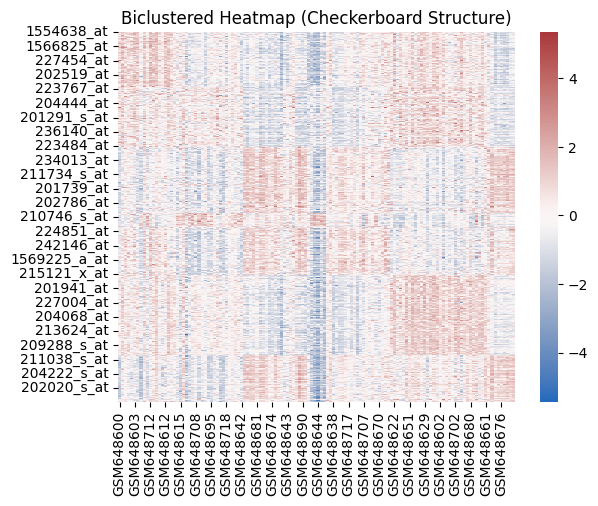

In [163]:
# Jalankan model biclustering
model = SpectralCoclustering(n_clusters=7, random_state=0)
model.fit(scaled_exprs_data)

# Urutkan data berdasarkan hasil biclustering
fit_data = scaled_exprs_data.iloc[np.argsort(model.row_labels_)]
fit_data = fit_data.iloc[:, np.argsort(model.column_labels_)]

sns.heatmap(fit_data, cmap="vlag")
plt.title("Biclustered Heatmap (Checkerboard Structure)")
plt.show()

In [164]:
# Hitung MSR dan VAF
X = scaled_exprs_data.values
overall_mean = X.mean()
row_labels = model.row_labels_
col_labels = model.column_labels_
n_clusters = model.n_clusters

results = []

for i in range(n_clusters):
    row_idx, col_idx = model.get_indices(i)
    bicluster = X[np.ix_(row_idx, col_idx)]

    # Hitung MSR
    row_mean = bicluster.mean(axis=1, keepdims=True)
    col_mean = bicluster.mean(axis=0, keepdims=True)
    bicluster_mean = bicluster.mean()

    msr = np.mean((bicluster - row_mean - col_mean + bicluster_mean) ** 2)

    # Hitung VAF
    numerator = np.sum((bicluster - bicluster.mean()) ** 2)
    denominator = np.sum((bicluster - overall_mean) ** 2)
    vaf = 1 - (numerator / denominator) if denominator != 0 else 0

    results.append({
        'Bicluster': i,
        'MSR': msr,
        'VAF': vaf,
        'n_genes': len(row_idx),
        'n_samples': len(col_idx)
    })

# Tampilkan sebagai DataFrame
result_df = pd.DataFrame(results)
print(result_df)

# Hitung rata-rata MSR dan VAF
avg_msr = result_df['MSR'].mean()
avg_vaf = result_df['VAF'].mean()

print(f"Rata-rata MSR dari seluruh bicluster: {avg_msr:.4f}")
print(f"Rata-rata VAF dari seluruh bicluster: {avg_vaf:.4f}")

   Bicluster       MSR       VAF  n_genes  n_samples
0          0  0.327670  0.647202      319         18
1          1  0.530462  0.088676      345         23
2          2  0.384765  0.535043      377         22
3          3  0.483704  0.654373       90          5
4          4  0.271973  0.500750      270         21
5          5  0.326411  0.702739      460         31
6          6  0.156962  0.763544      268         10
Rata-rata MSR dari seluruh bicluster: 0.3546
Rata-rata VAF dari seluruh bicluster: 0.5560


In [165]:
# --- Hitung coherence score (variansi bicluster) ---
coherence_scores = []

for i in range(model.n_clusters):
    rows = model.rows_[i]
    cols = model.columns_[i]

    bicluster = scaled_exprs_data.values[np.ix_(rows, cols)]

    if bicluster.size > 0:
        variance = np.var(bicluster)
        coherence_scores.append(variance)
    else:
        coherence_scores.append(np.nan)

# --- Tampilkan hasil coherence ---
for i, score in enumerate(coherence_scores):
    print(f"Bicluster {i+1}: Variansi = {score:.4f}")

# --- Hitung dan tampilkan rata-rata variansi ---
valid_scores = [score for score in coherence_scores if not np.isnan(score)]
average_variance = np.mean(valid_scores)
print(f"\nRata-rata variansi semua bicluster: {average_variance:.4f}")

Bicluster 1: Variansi = 0.5476
Bicluster 2: Variansi = 0.6753
Bicluster 3: Variansi = 0.6268
Bicluster 4: Variansi = 0.8949
Bicluster 5: Variansi = 0.4475
Bicluster 6: Variansi = 0.4141
Bicluster 7: Variansi = 0.2895

Rata-rata variansi semua bicluster: 0.5565


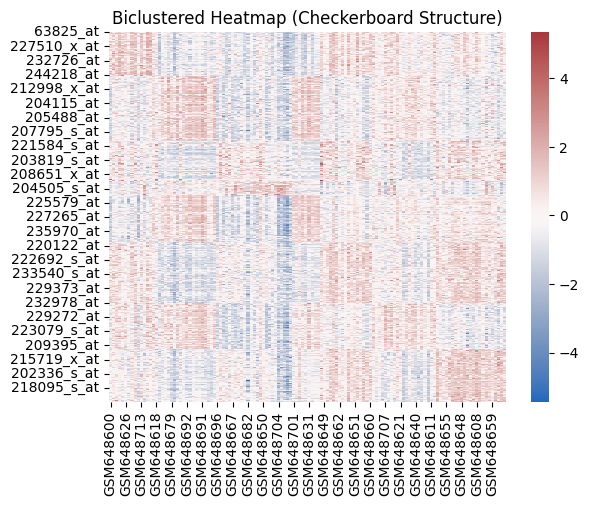

In [166]:
# Jalankan model biclustering
model = SpectralCoclustering(n_clusters=8, random_state=0)
model.fit(scaled_exprs_data)

# Urutkan data berdasarkan hasil biclustering
fit_data = scaled_exprs_data.iloc[np.argsort(model.row_labels_)]
fit_data = fit_data.iloc[:, np.argsort(model.column_labels_)]

sns.heatmap(fit_data, cmap="vlag")
plt.title("Biclustered Heatmap (Checkerboard Structure)")
plt.show()

In [167]:
# Hitung MSR dan VAF
X = scaled_exprs_data.values
overall_mean = X.mean()
row_labels = model.row_labels_
col_labels = model.column_labels_
n_clusters = model.n_clusters

results = []

for i in range(n_clusters):
    row_idx, col_idx = model.get_indices(i)
    bicluster = X[np.ix_(row_idx, col_idx)]

    # Hitung MSR
    row_mean = bicluster.mean(axis=1, keepdims=True)
    col_mean = bicluster.mean(axis=0, keepdims=True)
    bicluster_mean = bicluster.mean()

    msr = np.mean((bicluster - row_mean - col_mean + bicluster_mean) ** 2)

    # Hitung VAF
    numerator = np.sum((bicluster - bicluster.mean()) ** 2)
    denominator = np.sum((bicluster - overall_mean) ** 2)
    vaf = 1 - (numerator / denominator) if denominator != 0 else 0

    results.append({
        'Bicluster': i,
        'MSR': msr,
        'VAF': vaf,
        'n_genes': len(row_idx),
        'n_samples': len(col_idx)
    })

# Tampilkan sebagai DataFrame
result_df = pd.DataFrame(results)
print(result_df)

# Hitung rata-rata MSR dan VAF
avg_msr = result_df['MSR'].mean()
avg_vaf = result_df['VAF'].mean()

print(f"Rata-rata MSR dari seluruh bicluster: {avg_msr:.4f}")
print(f"Rata-rata VAF dari seluruh bicluster: {avg_vaf:.4f}")

   Bicluster       MSR       VAF  n_genes  n_samples
0          0  0.305924  0.641358      256         14
1          1  0.377531  0.573249      374         21
2          2  0.617485  0.117829      226         20
3          3  0.435399  0.688711       84          5
4          4  0.142595  0.807845      268          9
5          5  0.323028  0.591561      350         17
6          6  0.272577  0.499915      269         21
7          7  0.293834  0.728356      302         23
Rata-rata MSR dari seluruh bicluster: 0.3460
Rata-rata VAF dari seluruh bicluster: 0.5811


In [168]:
# --- Hitung coherence score (variansi bicluster) ---
coherence_scores = []

for i in range(model.n_clusters):
    rows = model.rows_[i]
    cols = model.columns_[i]

    bicluster = scaled_exprs_data.values[np.ix_(rows, cols)]

    if bicluster.size > 0:
        variance = np.var(bicluster)
        coherence_scores.append(variance)
    else:
        coherence_scores.append(np.nan)

# --- Tampilkan hasil coherence ---
for i, score in enumerate(coherence_scores):
    print(f"Bicluster {i+1}: Variansi = {score:.4f}")

# --- Hitung dan tampilkan rata-rata variansi ---
valid_scores = [score for score in coherence_scores if not np.isnan(score)]
average_variance = np.mean(valid_scores)
print(f"\nRata-rata variansi semua bicluster: {average_variance:.4f}")

Bicluster 1: Variansi = 0.5524
Bicluster 2: Variansi = 0.5966
Bicluster 3: Variansi = 0.8108
Bicluster 4: Variansi = 0.8163
Bicluster 5: Variansi = 0.2510
Bicluster 6: Variansi = 0.4558
Bicluster 7: Variansi = 0.4479
Bicluster 8: Variansi = 0.4238

Rata-rata variansi semua bicluster: 0.5443


In [169]:
# Dapatkan label untuk baris (gen) dan kolom (sampel)
row_labels = model.row_labels_
col_labels = model.column_labels_

# Buat DataFrame untuk melihat jumlah anggota tiap cluster
row_cluster_counts = pd.Series(row_labels).value_counts().sort_index()
col_cluster_counts = pd.Series(col_labels).value_counts().sort_index()

print("Jumlah gen per bicluster (baris):")
print(row_cluster_counts)

print("\nJumlah sampel per bicluster (kolom):")
print(col_cluster_counts)

Jumlah gen per bicluster (baris):
0    256
1    374
2    226
3     84
4    268
5    350
6    269
7    302
Name: count, dtype: int64

Jumlah sampel per bicluster (kolom):
0    14
1    21
2    20
3     5
4     9
5    17
6    21
7    23
Name: count, dtype: int64


In [170]:
# Menambahkan data bicluster ke df
scaled_expression_df["Bicluster"] = model.row_labels_

### **Analisis Gene Ontology**

In [171]:
# Load data annotasi untuk GO
# 1. Baca file, tapi lewati semua baris sampai '!platform_table_begin'
filepath = 'GPL570.annot'

with open(filepath, 'r') as file:
    lines = file.readlines()

# Cari indeks di mana tabel data mulai
for idx, line in enumerate(lines):
    if line.startswith('!platform_table_begin'):
        start_idx = idx + 1  # data mulai setelah baris ini
        break

# 2. Baca tabel mulai dari 'start_idx'
# Gabungkan lines mulai dari baris start_idx
table_lines = lines[start_idx:]

# Bikin dataframe dari string
from io import StringIO
df = pd.read_csv(StringIO(''.join(table_lines)), sep='\t')

# 3. Lihat kolom-kolom yang ada
print(df.columns.tolist())

# 4. Fokus hanya kolom penting: ID, Gene symbol, GO terms
df_go = df[['ID', 'Gene symbol', 'Gene title']]

['ID', 'Gene title', 'Gene symbol', 'Gene ID', 'UniGene title', 'UniGene symbol', 'UniGene ID', 'Nucleotide Title', 'GI', 'GenBank Accession', 'Platform_CLONEID', 'Platform_ORF', 'Platform_SPOTID', 'Chromosome location', 'Chromosome annotation', 'GO:Function', 'GO:Process', 'GO:Component', 'GO:Function ID', 'GO:Process ID', 'GO:Component ID']


In [172]:
df_go.dropna(inplace=True)

#### **Analisis DEG**

In [173]:
# Filter df_go untuk mengambil hanya ID yang ada dalam gen_upregulated
df_upregulated = df_go[df_go['ID'].isin(gen_upregulated)]

# Ambil 10 ID pertama (Top 10)
top_10_upregulated = df_upregulated.head(10)

# Tampilkan hanya kolom ID dan Gene title
top_10_output = top_10_upregulated[['ID', 'Gene symbol', 'Gene title']]

# Tampilkan hasilnya
top_10_output

ID Gene symbol                           Gene title
8        1405_i_at        CCL5         C-C motif chemokine ligand 5
53    1552316_a_at      GIMAP1         GTPase, IMAP family member 1
54      1552318_at      GIMAP1         GTPase, IMAP family member 1
625   1553132_a_at        TC2N           tandem C2 domains, nuclear
659     1553177_at      SH2D1B             SH2 domain containing 1B
976   1553589_a_at    PDZK1IP1          PDZK1 interacting protein 1
1036  1553678_a_at       ITGB1              integrin subunit beta 1
1156  1553856_s_at      P2RY10            purinergic receptor P2Y10
1244    1553979_at      ZNF121              zinc finger protein 121
1304    1554067_at    C12orf66  chromosome 12 open reading frame 66

In [174]:
# Filter df_go untuk mengambil hanya ID yang ada dalam gen_upregulated
df_downregulated = df_go[df_go['ID'].isin(gen_downregulated)]

# Ambil 10 ID pertama (Top 10)
top_10_downregulated = df_downregulated.head(10)

# Tampilkan hanya kolom ID dan Gene title
top_10_output_2 = top_10_downregulated[['ID', 'Gene symbol','Gene title']]

# Tampilkan hasilnya
top_10_output_2

ID     Gene symbol  \
17     1552263_at           MAPK1   
23     1552274_at             PXK   
160    1552485_at           LACTB   
161  1552486_s_at           LACTB   
208  1552553_a_at           NLRC4   
209  1552554_a_at           NLRC4   
292  1552670_a_at         PPP1R3B   
315  1552701_a_at          CARD16   
316  1552703_s_at  CARD16///CASP1   
368    1552772_at          CLEC4D   

                                            Gene title  
17                  mitogen-activated protein kinase 1  
23   PX domain containing serine/threonine kinase like  
160                                     lactamase beta  
161                                     lactamase beta  
208                NLR family CARD domain containing 4  
209                NLR family CARD domain containing 4  
292        protein phosphatase 1 regulatory subunit 3B  
315        caspase recruitment domain family member 16  
316  caspase recruitment domain family member 16///...  
368             C-type lectin domain family 4 member D

#### **Analisis Klasifikasi**

In [175]:
# Filter df_go untuk mengambil hanya fitur yang ada dalam common_features_array
df_common_features = df_go[df_go['ID'].isin(top_10_gen_list)]

# Tampilkan hanya kolom ID dan Gene title untuk semua fitur yang ditemukan
all_common_features_output = df_common_features[['ID', 'Gene symbol', 'Gene title']]

# Tampilkan hasilnya
all_common_features_output

ID      Gene symbol  \
12029    202581_at  HSPA1B///HSPA1A   
12682    203234_at             UPP1   
19317  209911_x_at        HIST1H2BD   
23430    214131_at           TXLNGY   
32921  223645_s_at           TXLNGY   
32922  223646_s_at           TXLNGY   
36475    227220_at            NFXL1   
39688    230434_at         PHOSPHO2   
40854    231600_at          CLEC12B   
48198    238949_at           RNF145   

                                              Gene title  
12029  heat shock protein family A (Hsp70) member 1B/...  
12682                            uridine phosphorylase 1  
19317                            histone cluster 1, H2bd  
23430                 taxilin gamma pseudogene, Y-linked  
32921                 taxilin gamma pseudogene, Y-linked  
32922                 taxilin gamma pseudogene, Y-linked  
36475  nuclear transcription factor, X-box binding li...  
39688                              phosphatase, orphan 2  
40854            C-type lectin domain family 12 member B  
48198                            ring finger protein 145

#### **Analisis Clustering**

In [176]:
# Menampilkan sebagian gen dari masing-masing cluster
cluster_0_indices = scaled_expression_df[scaled_expression_df['Cluster_HDBSCAN'] == 0].index
cluster_1_indices = scaled_expression_df[scaled_expression_df['Cluster_HDBSCAN'] == 1].index

# Menampilkan indeks dari Cluster 0 dan Cluster 1
print("Anggota Cluster 0:")
print(cluster_0_indices)

print("\nAnggota Cluster 1:")
print(cluster_1_indices)

Anggota Cluster 0:
Index(['1405_i_at', '1552316_a_at', '1552318_at', '1553132_a_at', '1553177_at',
       '1553678_a_at', '1553856_s_at', '1553979_at', '1554067_at',
       '1554250_s_at',
       ...
       '244414_at', '244878_at', '34210_at', '37145_at', '38241_at',
       '39248_at', '39318_at', '44790_s_at', '57082_at', '74694_s_at'],
      dtype='object', length=856)

Anggota Cluster 1:
Index(['1552263_at', '1552274_at', '1552485_at', '1552486_s_at',
       '1552553_a_at', '1552554_a_at', '1552670_a_at', '1552701_a_at',
       '1552703_s_at', '1552772_at',
       ...
       '244502_at', '244548_at', '244579_at', '244636_at', '244774_at',
       '55692_at', '58780_s_at', '63825_at', '87100_at',
       'AFFX-HSAC07/X00351_5_at'],
      dtype='object', length=1037)


In [177]:
# Menampilkan sebagian gen dari Cluster 0
cluster_0_ids = scaled_expression_df[scaled_expression_df['Cluster_HDBSCAN'] == 0].index

# Filter df_go berdasarkan kecocokan dengan kolom 'ID'
cluster_0_go_info = df_go[df_go['ID'].isin(cluster_0_ids)][['ID', 'Gene symbol', 'Gene title']]

# Hapus baris dengan informasi yang tidak lengkap
cluster_0_genes = cluster_0_go_info.dropna(subset=['ID', 'Gene symbol', 'Gene title'])

# Menampilkan 10 gen dari cluster 0
cluster_0_genes.head(10)

ID                 Gene symbol  \
8        1405_i_at                        CCL5   
53    1552316_a_at                      GIMAP1   
54      1552318_at                      GIMAP1   
625   1553132_a_at                        TC2N   
659     1553177_at                      SH2D1B   
1036  1553678_a_at                       ITGB1   
1156  1553856_s_at                      P2RY10   
1244    1553979_at                      ZNF121   
1304    1554067_at                    C12orf66   
1431  1554250_s_at  STAG3L2///STAG3L3///TRIM73   

                                             Gene title  
8                          C-C motif chemokine ligand 5  
53                         GTPase, IMAP family member 1  
54                         GTPase, IMAP family member 1  
625                          tandem C2 domains, nuclear  
659                            SH2 domain containing 1B  
1036                            integrin subunit beta 1  
1156                          purinergic receptor P2Y10  
1244                            zinc finger protein 121  
1304                chromosome 12 open reading frame 66  
1431  stromal antigen 3-like 2 (pseudogene)///stroma...

In [178]:
# Menampilkan sebagian gen dari Cluster 0
cluster_1_ids = scaled_expression_df[scaled_expression_df['Cluster_HDBSCAN'] == 1].index

# Filter df_go berdasarkan kecocokan dengan kolom 'ID'
cluster_1_go_info = df_go[df_go['ID'].isin(cluster_1_ids)][['ID', 'Gene symbol', 'Gene title']]

# Hapus baris dengan informasi yang tidak lengkap
cluster_1_genes = cluster_1_go_info.dropna(subset=['ID', 'Gene symbol', 'Gene title'])

# Menampilkan 10 gen dari cluster 0
cluster_1_genes.head(10)

ID     Gene symbol  \
17     1552263_at           MAPK1   
23     1552274_at             PXK   
160    1552485_at           LACTB   
161  1552486_s_at           LACTB   
208  1552553_a_at           NLRC4   
209  1552554_a_at           NLRC4   
292  1552670_a_at         PPP1R3B   
315  1552701_a_at          CARD16   
316  1552703_s_at  CARD16///CASP1   
368    1552772_at          CLEC4D   

                                            Gene title  
17                  mitogen-activated protein kinase 1  
23   PX domain containing serine/threonine kinase like  
160                                     lactamase beta  
161                                     lactamase beta  
208                NLR family CARD domain containing 4  
209                NLR family CARD domain containing 4  
292        protein phosphatase 1 regulatory subunit 3B  
315        caspase recruitment domain family member 16  
316  caspase recruitment domain family member 16///...  
368             C-type lectin domain family 4 member D

#### **Analisis Biclustering**

In [179]:
# Menampilkan sebagian gen dari Bicluster
cluster_bi = scaled_expression_df[scaled_expression_df['Bicluster'] == 0].index

# Filter df_go berdasarkan kecocokan dengan kolom 'ID'
cluster_bi_info = df_go[df_go['ID'].isin(cluster_bi)][['ID', 'Gene symbol', 'Gene title']]

# Hapus baris dengan informasi yang tidak lengkap
cluster_bi_genes = cluster_bi_info.dropna(subset=['ID', 'Gene symbol', 'Gene title'])

# Menampilkan 10 gen dari cluster 0
cluster_bi_genes.head(3)

ID Gene symbol  \
23    1552274_at         PXK   
1204  1553920_at     C9orf84   
1718  1554638_at     ZFYVE16   

                                             Gene title  
23    PX domain containing serine/threonine kinase like  
1204                 chromosome 9 open reading frame 84  
1718                zinc finger FYVE-type containing 16

In [180]:
# Menampilkan sebagian gen dari Bicluster
cluster_bi = scaled_expression_df[scaled_expression_df['Bicluster'] == 1].index

# Filter df_go berdasarkan kecocokan dengan kolom 'ID'
cluster_bi_info = df_go[df_go['ID'].isin(cluster_bi)][['ID', 'Gene symbol', 'Gene title']]

# Hapus baris dengan informasi yang tidak lengkap
cluster_bi_genes = cluster_bi_info.dropna(subset=['ID', 'Gene symbol', 'Gene title'])

# Menampilkan 10 gen dari cluster 0
cluster_bi_genes.head(3)

ID Gene symbol                    Gene title
8       1405_i_at        CCL5  C-C motif chemokine ligand 5
625  1553132_a_at        TC2N    tandem C2 domains, nuclear
659    1553177_at      SH2D1B      SH2 domain containing 1B

In [181]:
# Menampilkan sebagian gen dari Bicluster
cluster_bi = scaled_expression_df[scaled_expression_df['Bicluster'] == 2].index

# Filter df_go berdasarkan kecocokan dengan kolom 'ID'
cluster_bi_info = df_go[df_go['ID'].isin(cluster_bi)][['ID', 'Gene symbol', 'Gene title']]

# Hapus baris dengan informasi yang tidak lengkap
cluster_bi_genes = cluster_bi_info.dropna(subset=['ID', 'Gene symbol', 'Gene title'])

# Menampilkan 10 gen dari cluster 0
cluster_bi_genes.head(4)

ID Gene symbol                                   Gene title
315  1552701_a_at      CARD16  caspase recruitment domain family member 16
368    1552772_at      CLEC4D       C-type lectin domain family 4 member D
369    1552773_at      CLEC4D       C-type lectin domain family 4 member D
988  1553605_a_at      ABCA13   ATP binding cassette subfamily A member 13

In [182]:
# Menampilkan sebagian gen dari Bicluster
cluster_bi = scaled_expression_df[scaled_expression_df['Bicluster'] == 3].index

# Filter df_go berdasarkan kecocokan dengan kolom 'ID'
cluster_bi_info = df_go[df_go['ID'].isin(cluster_bi)][['ID', 'Gene symbol', 'Gene title']]

# Hapus baris dengan informasi yang tidak lengkap
cluster_bi_genes = cluster_bi_info.dropna(subset=['ID', 'Gene symbol', 'Gene title'])

# Menampilkan 10 gen dari cluster 0
cluster_bi_genes.head(3)

ID Gene symbol                   Gene title
976    1553589_a_at    PDZK1IP1  PDZK1 interacting protein 1
2903   1556283_s_at    FGFR1OP2     FGFR1 oncogene partner 2
10557   201109_s_at       THBS1             thrombospondin 1

In [183]:
# Menampilkan sebagian gen dari Bicluster
cluster_bi = scaled_expression_df[scaled_expression_df['Bicluster'] == 4].index

# Filter df_go berdasarkan kecocokan dengan kolom 'ID'
cluster_bi_info = df_go[df_go['ID'].isin(cluster_bi)][['ID', 'Gene symbol', 'Gene title']]

# Hapus baris dengan informasi yang tidak lengkap
cluster_bi_genes = cluster_bi_info.dropna(subset=['ID', 'Gene symbol', 'Gene title'])

# Menampilkan 10 gen dari cluster 0
cluster_bi_genes.head(4)

ID Gene symbol                    Gene title
53    1552316_a_at      GIMAP1  GTPase, IMAP family member 1
54      1552318_at      GIMAP1  GTPase, IMAP family member 1
1036  1553678_a_at       ITGB1       integrin subunit beta 1
1244    1553979_at      ZNF121       zinc finger protein 121

In [184]:
# Menampilkan sebagian gen dari Bicluster
cluster_bi = scaled_expression_df[scaled_expression_df['Bicluster'] == 5].index

# Filter df_go berdasarkan kecocokan dengan kolom 'ID'
cluster_bi_info = df_go[df_go['ID'].isin(cluster_bi)][['ID', 'Gene symbol', 'Gene title']]

# Hapus baris dengan informasi yang tidak lengkap
cluster_bi_genes = cluster_bi_info.dropna(subset=['ID', 'Gene symbol', 'Gene title'])

# Menampilkan 10 gen dari cluster 0
cluster_bi_genes.head(3)

ID Gene symbol                                    Gene title
747   1553297_a_at       CSF3R          colony stimulating factor 3 receptor
1072    1553723_at      ADGRG3        adhesion G protein-coupled receptor G3
1382  1554178_a_at     FAM126B  family with sequence similarity 126 member B

In [185]:
# Menampilkan sebagian gen dari Bicluster
cluster_bi = scaled_expression_df[scaled_expression_df['Bicluster'] == 6].index

# Filter df_go berdasarkan kecocokan dengan kolom 'ID'
cluster_bi_info = df_go[df_go['ID'].isin(cluster_bi)][['ID', 'Gene symbol', 'Gene title']]

# Hapus baris dengan informasi yang tidak lengkap
cluster_bi_genes = cluster_bi_info.dropna(subset=['ID', 'Gene symbol', 'Gene title'])

# Menampilkan 10 gen dari cluster 0
cluster_bi_genes.head(3)

ID                 Gene symbol  \
1431  1554250_s_at  STAG3L2///STAG3L3///TRIM73   
1831    1554786_at                       CASS4   
3520    1557239_at                         BBX   

                                             Gene title  
1431  stromal antigen 3-like 2 (pseudogene)///stroma...  
1831            Cas scaffolding protein family member 4  
3520                            BBX, HMG-box containing

In [186]:
# Menampilkan sebagian gen dari Bicluster
cluster_bi = scaled_expression_df[scaled_expression_df['Bicluster'] == 7].index

# Filter df_go berdasarkan kecocokan dengan kolom 'ID'
cluster_bi_info = df_go[df_go['ID'].isin(cluster_bi)][['ID', 'Gene symbol', 'Gene title']]

# Hapus baris dengan informasi yang tidak lengkap
cluster_bi_genes = cluster_bi_info.dropna(subset=['ID', 'Gene symbol', 'Gene title'])

# Menampilkan 10 gen dari cluster 0
cluster_bi_genes.head(4)

ID Gene symbol                           Gene title
17     1552263_at       MAPK1   mitogen-activated protein kinase 1
160    1552485_at       LACTB                       lactamase beta
161  1552486_s_at       LACTB                       lactamase beta
208  1552553_a_at       NLRC4  NLR family CARD domain containing 4

In [187]:
# Menyimpan hasil analisis untuk GO Enrichment di R
scaled_expression_df[['Cluster_HDBSCAN', 'Bicluster']].to_csv('GO2.csv', index=True)